In [1]:
# System modules
import os
import sys
from dotenv import load_dotenv
import logging
import requests
from hashlib import md5
import json

# ML modules
import pandas as pd
import numpy as np

# Viz modules
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



# Append source directory to system path
src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# Helper functions
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


load_dotenv()  # take environment variables from .env.

YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")


In [2]:
def yelp_business_search_by_location(
    location: str = "Paris", count: int = 200
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Get Yelp data from API.

    Params:
        location: str
        count: int

    Returns:
        json
    """
    headers = {
        "Authorization": f"Bearer {YELP_API_KEY}",
    }
    limit = 50

    businesses = pd.DataFrame()
    reviews = pd.DataFrame()
    photos = pd.DataFrame()
    for offset in range(0, count, limit):
        businesses_request = requests.get(
            "https://api.yelp.com/v3/businesses/search",
            headers=headers,
            params={
                "location": location,
                "limit": limit,
                "offset": offset,
            },
        )

        if businesses_request.status_code == 200:
            businesses_data = businesses_request.json()
            businesses = businesses.append(
                pd.DataFrame(businesses_data["businesses"]), ignore_index=True
            )

            for business in businesses_data["businesses"]:
                business_detail_request = requests.get(
                    f"https://api.yelp.com/v3/businesses/{business['id']}",
                    headers=headers,
                )
                if business_detail_request.status_code == 200:
                    business_detail_data = business_detail_request.json()
                    photos = photos.append(
                        pd.DataFrame(business_detail_data["photos"]),
                        ignore_index=True,
                    )
                else:
                    raise Exception(
                        f"Yelp API request failed with status code \
                             { business_detail_request.status_code }. \
                                 Response text: { business_detail_request.text }"
                    )

            for business in businesses_data["businesses"]:
                business_reviews_request = requests.get(
                    f"https://api.yelp.com/v3/businesses/{business['id']}/reviews",
                    headers=headers,
                )
                if business_reviews_request.status_code == 200:
                    business_reviews_data = business_reviews_request.json()
                    reviews = reviews.append(
                        pd.DataFrame(business_reviews_data["reviews"]),
                        ignore_index=True,
                    )
                else:
                    raise Exception(
                        f"Yelp API request failed with status code { business_reviews_request.status_code }. Response text: { business_reviews_request.text }"
                    )

        else:
            raise Exception(
                f"Yelp API request failed with status code { businesses_request.status_code }. Response text: { businesses_request.text }"
            )

    return businesses, reviews, photos


In [3]:
def get_yelp_data(
    locations: list[str] = [
        "Paris",
        "New York City",
        "Tokyo",
        "Rio de Janeiro",
        "Sydney",
    ],
    category: str = "restaurants",
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Get Yelp data from API.

    - iterate over the locations
        - build a GraphQL query to get the data
        - send the query to the Yelp API
        - parse the response
        - append to the dataframe
    - return the dataframes

    Params:
        locations: str[] (default: ["Paris"]) - List of Yelp locations to search
        category: str (default: "restaurants") - Yelp category (see https://www.yelp.com/developers/documentation/v3/all_category_list)

    Returns:
        businesses: pd.DataFrame - businesses data from Yelp API request
        reviews: pd.DataFrame - reviews data from Yelp API request
        photos: pd.DataFrame - photos data from Yelp API request
    """
    # businesses data (see https://www.yelp.com/developers/graphql/objects/business)
    businesses = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of this business.
            "business_review_count",  # Total number of reviews for this business.
            "business_rating",  # Rating of the business, which is an average of the ratings of all reviews.
            "business_price",  # Price range of the business, from "$" to "$$$$" (inclusive).
            "business_city",  # City of this business.
            "business_state",  # ISO 3166-2 (with a few exceptions) state code of this business (see https://www.yelp.com/developers/documentation/v3/state_codes).
            "business_postal_code",  # Postal code of this business (see https://en.wikipedia.org/wiki/Postal_code)
            "business_country",  # ISO 3166-1 alpha-2 country code of this business.
            "business_latitude",  # Latitude of the business.
            "business_longitude",  # Longitude of the business.
            "business_categories",  # List of categories the business belongs to.
            "business_parent_categories",  # List of parent categories the business belongs to.
        ]
    )
    reviews = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of the business.
            "review_text",  # Text excerpt of this review.
            "review_rating",  # Rating of this review.
        ]
    )
    photos = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of the business.
            "photo_url",  # URL of the photo.
        ]
    )

    # Yelp's GraphQL endpoint
    url = "https://api.yelp.com/v3/graphql"
    # Request headers
    headers = {
        "Authorization": f"Bearer {YELP_API_KEY}",
        "Content-Type": "application/graphql",
    }
    count = 200  # Yelp's GraphQL API returns a maximum of 240 total results
    limit = 50  # Yelp's GraphQL API returns a maximum of 50 results per request

    for location in locations:
        for offset in range(0, count, limit):
            # Build the GraphQL query
            query = f'{{\n\
        search(categories: "{ category }", location: "{ location }", offset: { offset }, limit:  { limit }) {{\n\
            business {{\n\
                alias\n\
                review_count\n\
                rating\n\
                price\n\
                location {{\n\
                    city\n\
                    state\n\
                    postal_code\n\
                    country\n\
                }}\n\
                coordinates {{\n\
                    latitude\n\
                    longitude\n\
                }}\n\
                categories {{\n\
                    alias\n\
                    parent_categories {{\n\
                        alias\n\
                    }}\n\
                }}\n\
                photos\n\
                reviews {{\n\
                    text\n\
                    rating\n\
                }}\n\
            }}\n\
        }}\n\
    }}'
            # Send the query to the Yelp API
            response = requests.post(url, headers=headers, data=query)
            # Parse the response
            if not response.status_code == 200:
                raise Exception(
                    f"Yelp API request failed with status code { response.status_code }. Response text: { response.text }"
                )

            # Parse the response
            data = response.json()

            if "errors" in data:
                raise Exception(
                    f"Yelp API request failed with errors: { data['errors'] }"
                )

            for business in (
                data.get("data", {}).get("search", {}).get("business", [])
            ):
                # Add the business data to the dataframe
                businesses = businesses.append(
                    {
                        "business_alias": business.get("alias"),
                        "business_review_count": business.get("review_count"),
                        "business_rating": business.get("rating"),
                        "business_price": len(  # count the number of characters ($, €, ...)
                            business.get("price")
                        )
                        if business.get("price") is not None
                        else 0,
                        "business_city": business.get("location", {}).get(
                            "city"
                        ),
                        "business_state": business.get("location", {}).get(
                            "state"
                        ),
                        "business_postal_code": business.get(
                            "location", {}
                        ).get("postal_code"),
                        "business_country": business.get("location", {}).get(
                            "country"
                        ),
                        "business_latitude": business.get(
                            "coordinates", {}
                        ).get("latitude"),
                        "business_longitude": business.get(
                            "coordinates", {}
                        ).get("longitude"),
                        "business_categories": json.dumps(
                            list(
                                set(  # keep unique values
                                    [
                                        cat.get("alias")
                                        for cat in business.get(
                                            "categories", []
                                        )
                                    ]
                                )
                            )
                        ),
                        "business_parent_categories": json.dumps(
                            list(
                                set(  # keep unique values
                                    [
                                        parent_cat.get("alias")
                                        for cat in business.get(
                                            "categories", []
                                        )
                                        for parent_cat in cat.get(
                                            "parent_categories", []
                                        )
                                    ]
                                )
                            )
                        ),
                    },
                    ignore_index=True,
                )

                for photo in business.get("photos", []) or []:
                    # Add the photo data to the dataframe
                    photos = photos.append(
                        {
                            "business_alias": business.get("alias"),
                            "photo_url": photo,
                        },
                        ignore_index=True,
                    )

                for review in business.get("reviews", []) or []:
                    # Add the review data to the dataframe
                    reviews = reviews.append(
                        {
                            "business_alias": business.get("alias"),
                            "review_text": review.get("text"),
                            "review_rating": review.get("rating"),
                        },
                        ignore_index=True,
                    )

    # Return the dataframes
    return businesses, reviews, photos


def download_photos(
    photos: pd.DataFrame,
    target_path: str,
) -> None:
    # Check if content path exists
    if not os.path.exists(target_path):
        logging.info(f"Creating {target_path}")
        os.makedirs(target_path)

    for photo in photos.itertuples(index=False):
        file_name = f"{ photo.business_alias }_{ md5(photo.photo_url.encode('utf-8')).hexdigest() }.jpg"
        file_path = os.path.join(target_path, file_name)

        if not os.path.exists(file_path):
            request = requests.get(photo.photo_url)
            if not 200 == request.status_code:
                logging.warning(
                    f"Photo URL : { photo.photo_url }\nYelp API request failed with status code: { request.status_code }.\nResponse text: { request.text }"
                )
                continue

            photo_data = request.content
            with open(file_path, "wb") as f:
                f.write(photo_data)


In [4]:
data_path = "../data/raw/"
businesses_csv_path = os.path.join(data_path, "businesses.csv")
reviews_csv_path = os.path.join(data_path, "reviews.csv")
photos_csv_path = os.path.join(data_path, "photos.csv")

if not os.path.exists(data_path):
    logging.info(f"Creating {data_path}")
    os.makedirs(data_path)

if (
    os.path.exists(businesses_csv_path)
    and os.path.exists(reviews_csv_path)
    and os.path.exists(photos_csv_path)
):
    logging.info(f"Data already downloaded")
    businesses_df = pd.read_csv(businesses_csv_path)
    reviews_df = pd.read_csv(reviews_csv_path)
    photos_df = pd.read_csv(photos_csv_path)
else:
    logging.info("Saving data")
    businesses_df, reviews_df, photos_df = get_yelp_data()

    businesses_df.to_csv(businesses_csv_path, index=False)
    reviews_df.to_csv(reviews_csv_path, index=False)
    photos_df.to_csv(photos_csv_path, index=False)


# Fix dtypes
businesses_df["business_alias"] = businesses_df["business_alias"].astype(str)
businesses_df["business_review_count"] = businesses_df[
    "business_review_count"
].astype(int)
businesses_df["business_rating"] = businesses_df["business_rating"].astype(
    float
)
businesses_df["business_price"] = businesses_df["business_price"].astype(int)
businesses_df["business_city"] = businesses_df["business_city"].astype(str)
businesses_df["business_state"] = businesses_df["business_state"].astype(str)
businesses_df["business_postal_code"] = businesses_df[
    "business_postal_code"
].astype(str)
businesses_df["business_country"] = businesses_df["business_country"].astype(
    str
)
businesses_df["business_latitude"] = businesses_df["business_latitude"].astype(
    float
)
businesses_df["business_longitude"] = businesses_df[
    "business_longitude"
].astype(float)
businesses_df["business_categories"] = businesses_df[
    "business_categories"
].astype(str)
businesses_df["business_parent_categories"] = businesses_df[
    "business_parent_categories"
].astype(str)

reviews_df["business_alias"] = reviews_df["business_alias"].astype(str)
reviews_df["review_text"] = reviews_df["review_text"].astype(str)
reviews_df["review_rating"] = reviews_df["review_rating"].astype(float)

photos_df["business_alias"] = photos_df["business_alias"].astype(str)
photos_df["photo_url"] = photos_df["photo_url"].astype(str)


# Reduce memory usage
businesses_df = data_helpers.reduce_dataframe_memory_usage(businesses_df)
reviews_df = data_helpers.reduce_dataframe_memory_usage(reviews_df)
photos_df = data_helpers.reduce_dataframe_memory_usage(photos_df)


In [5]:
businesses_df.head()


business_alias  business_review_count  \
0  le-comptoir-de-la-gastronomie-paris                   1107   
1               l-as-du-fallafel-paris                   1810   
2                       angelina-paris                   1347   
3             l-avant-comptoir-paris-3                    612   
4               la-coïncidence-paris-4                    493   

   business_rating  business_price business_city business_state  \
0              4.5               2         Paris             75   
1              4.5               1         Paris             75   
2              4.0               3         Paris             75   
3              4.5               2         Paris             75   
4              4.5               2         Paris             75   

  business_postal_code business_country  business_latitude  \
0                75001               FR          48.864517   
1                75004               FR          48.857498   
2                75001               FR          48.865093   
3                75006               FR          48.852020   
4                75116               FR          48.868107   

   business_longitude                      business_categories  \
0            2.345402                               ["french"]   
1            2.359080      ["kosher", "falafel", "sandwiches"]   
2            2.328464  ["tea", "cakeshop", "breakfast_brunch"]   
3            2.338800                   ["wine_bars", "tapas"]   
4            2.284365                               ["french"]   

         business_parent_categories  
0                   ["restaurants"]  
1  ["restaurants", "mediterranean"]  
2           ["restaurants", "food"]  
3           ["bars", "restaurants"]  
4                   ["restaurants"]

In [6]:
businesses_df.describe(include="all")


business_alias  business_review_count  \
count                                  1000            1000.000000   
unique                                 1000                    NaN   
top     le-comptoir-de-la-gastronomie-paris                    NaN   
freq                                      1                    NaN   
mean                                    NaN             529.395000   
std                                     NaN            1134.869631   
min                                     NaN               6.000000   
25%                                     NaN              30.000000   
50%                                     NaN              71.000000   
75%                                     NaN             265.750000   
max                                     NaN           13047.000000   

        business_rating  business_price business_city business_state  \
count       1000.000000     1000.000000          1000           1000   
unique              NaN             NaN            40              6   
top                 NaN             NaN         Paris             13   
freq                NaN             NaN           200            200   
mean           4.270500        2.144000           NaN            NaN   
std            0.353135        0.897814           NaN            NaN   
min            3.000000        0.000000           NaN            NaN   
25%            4.000000        2.000000           NaN            NaN   
50%            4.500000        2.000000           NaN            NaN   
75%            4.500000        3.000000           NaN            NaN   
max            5.000000        4.000000           NaN            NaN   

       business_postal_code business_country  business_latitude  \
count                  1000             1000        1000.000000   
unique                  301                5                NaN   
top                    2000               AU                NaN   
freq                    139              200                NaN   
mean                    NaN              NaN          13.688472   
std                     NaN              NaN          34.823799   
min                     NaN              NaN         -33.897026   
25%                     NaN              NaN         -22.983292   
50%                     NaN              NaN          35.673141   
75%                     NaN              NaN          40.751259   
max                     NaN              NaN          48.890209   

        business_longitude business_categories business_parent_categories  
count          1000.000000                1000                       1000  
unique                 NaN                 530                         50  
top                    NaN          ["french"]            ["restaurants"]  
freq                   NaN                  56                        551  
mean             35.219700                 NaN                        NaN  
std              93.358452                 NaN                        NaN  
min             -74.016022                 NaN                        NaN  
25%             -43.218462                 NaN                        NaN  
50%               2.340317                 NaN                        NaN  
75%             139.770420                 NaN                        NaN  
max             151.298248                 NaN                        NaN

In [7]:
reviews_df.head()


business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1  le-comptoir-de-la-gastronomie-paris   
2  le-comptoir-de-la-gastronomie-paris   
3               l-as-du-fallafel-paris   
4               l-as-du-fallafel-paris   

                                         review_text  review_rating  
0  This review is from our 2019 trip.  Shame on m...            5.0  
1  This place def lives up the hype.  Best French...            5.0  
2  While planning a friends trip to Paris, I came...            5.0  
3  This is the best falafel sandwich I have ever ...            5.0  
4  IMO this is a must try in Paris. 

Located in ...            5.0

In [8]:
reviews_df.describe(include="all")


business_alias  \
count                                  2928   
unique                                  990   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      3   
mean                                    NaN   
std                                     NaN   
min                                     NaN   
25%                                     NaN   
50%                                     NaN   
75%                                     NaN   
max                                     NaN   

                                              review_text  review_rating  
count                                                2928    2928.000000  
unique                                               2928            NaN  
top     This review is from our 2019 trip.  Shame on m...            NaN  
freq                                                    1            NaN  
mean                                                  NaN       4.396516  
std                                                   NaN       0.904879  
min                                                   NaN       1.000000  
25%                                                   NaN       4.000000  
50%                                                   NaN       5.000000  
75%                                                   NaN       5.000000  
max                                                   NaN       5.000000

In [9]:
photos_df.head()


business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1               l-as-du-fallafel-paris   
2                       angelina-paris   
3             l-avant-comptoir-paris-3   
4               la-coïncidence-paris-4   

                                           photo_url  
0  https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...  
1  https://s3-media2.fl.yelpcdn.com/bphoto/wdIhzK...  
2  https://s3-media3.fl.yelpcdn.com/bphoto/DPM5TB...  
3  https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxg...  
4  https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgE...

In [10]:
photos_df.describe(include="all")


business_alias  \
count                                  1000   
unique                                 1000   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      1   

                                                photo_url  
count                                                1000  
unique                                               1000  
top     https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...  
freq                                                    1

In [11]:
download_photos(photos_df, target_path="../data/raw/photos/")


Yelp API request failed with status code: 403.
Response text: <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied</Message><RequestId>0DJBN0VHMJT13NBV</RequestId><HostId>j7TA0Eqsl2U7Pk9sRnBBYyeuaUBExlVpkcYhzHkXn4zsu0qgpDuUaEKoz9R/doeTSms/AlrqGj4=</HostId></Error>


In [12]:
def one_hot_encode_list_variables(
    df: pd.DataFrame,
    columns: list[str],
) -> pd.DataFrame:
    """One-hot encode list variables.
    See : https://cmpoi.medium.com/a-quick-tutorial-to-encode-list-variables-125ba4040325

    - for each list variable
        - decode JSON values to list
        - make a dataframe of one-hot encoded values
        - append to original dataframe

    Args:
        df (pd.DataFrame): dataframe to encode
        columns (list[str]): list of columns to encode

    Raises:
        Exception: columns values should be (JSON encoded) lists of strings

    Returns:
        pd.DataFrame:  dataframe with encoded columns
    """
    df = df.copy()
    for col in columns:
        if not isinstance(df[col][0], list):
            df[col] = df[col].replace(
                "[]", "null"
            )  # replace empty list with null
            df[col] = df[col].apply(json.loads)  # convert string to list

        if not isinstance(df[col][0], list):
            raise Exception(f"{col} is not a list")

        categories_df = (
            pd.get_dummies(
                pd.DataFrame(
                    [
                        x
                        if x is not None
                        else ["__EMPTY__"]  # replace None with empty list
                        for x in df[col].tolist()
                    ]
                ).stack(),
            )
            .groupby(level=0)
            .sum()
        ).drop(
            columns="__EMPTY__", errors="ignore"
        )  # remove empty list

        df = pd.concat([df, categories_df], axis=1)

    return df


df = one_hot_encode_list_variables(
    businesses_df, ["business_categories", "business_parent_categories"]
)


In [13]:
df.describe(include="all")


business_alias  business_review_count  \
count                                  1000            1000.000000   
unique                                 1000                    NaN   
top     le-comptoir-de-la-gastronomie-paris                    NaN   
freq                                      1                    NaN   
mean                                    NaN             529.395000   
std                                     NaN            1134.869631   
min                                     NaN               6.000000   
25%                                     NaN              30.000000   
50%                                     NaN              71.000000   
75%                                     NaN             265.750000   
max                                     NaN           13047.000000   

        business_rating  business_price business_city business_state  \
count       1000.000000     1000.000000          1000           1000   
unique              NaN             NaN            40              6   
top                 NaN             NaN         Paris             13   
freq                NaN             NaN           200            200   
mean           4.270500        2.144000           NaN            NaN   
std            0.353135        0.897814           NaN            NaN   
min            3.000000        0.000000           NaN            NaN   
25%            4.000000        2.000000           NaN            NaN   
50%            4.500000        2.000000           NaN            NaN   
75%            4.500000        3.000000           NaN            NaN   
max            5.000000        4.000000           NaN            NaN   

       business_postal_code business_country  business_latitude  \
count                  1000             1000        1000.000000   
unique                  301                5                NaN   
top                    2000               AU                NaN   
freq                    139              200                NaN   
mean                    NaN              NaN          13.688472   
std                     NaN              NaN          34.823799   
min                     NaN              NaN         -33.897026   
25%                     NaN              NaN         -22.983292   
50%                     NaN              NaN          35.673141   
75%                     NaN              NaN          40.751259   
max                     NaN              NaN          48.890209   

        business_longitude  ...     jpsweets        latin        media  \
count          1000.000000  ...  1000.000000  1000.000000  1000.000000   
unique                 NaN  ...          NaN          NaN          NaN   
top                    NaN  ...          NaN          NaN          NaN   
freq                   NaN  ...          NaN          NaN          NaN   
mean             35.219700  ...     0.001000     0.001000     0.003000   
std              93.358452  ...     0.031623     0.031623     0.054717   
min             -74.016022  ...     0.000000     0.000000     0.000000   
25%             -43.218462  ...     0.000000     0.000000     0.000000   
50%               2.340317  ...     0.000000     0.000000     0.000000   
75%             139.770420  ...     0.000000     0.000000     0.000000   
max             151.298248  ...     1.000000     1.000000     1.000000   

        mediterranean      mexican   mideastern    nightlife  \
count     1000.000000  1000.000000  1000.000000  1000.000000   
unique            NaN          NaN          NaN          NaN   
top               NaN          NaN          NaN          NaN   
freq              NaN          NaN          NaN          NaN   
mean         0.003000     0.004000     0.003000     0.060000   
std          0.054717     0.063151     0.054717     0.237606   
min          0.000000     0.000000     0.000000     0.000000   
25%          0.000000     0.000000     0.000000     0.000000   
50%          0.000000     0.000000     0.000000     0

## Commentaires clients


In [14]:
fig = px.histogram(reviews_df, x="review_rating", marginal="box")
fig.show()


In [15]:
from sklearn.model_selection import train_test_split


X = reviews_df["review_text"]
y = reviews_df["review_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Sentiment analysis : binary classification
y_bi = [0 if x < 5 else 1 for x in y]
y_train_bi = [0 if x < 5 else 1 for x in y_train]
y_test_bi = [0 if x < 5 else 1 for x in y_test]


In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


def pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


tokenizers = {
    "None": None,
    "stopwords": lambda text: [
        token.lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "PorterStemmer": lambda text: [
        PorterStemmer().stem(token).lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "WordNetLemmatizer": lambda text: [
        WordNetLemmatizer().lemmatize(token, pos_tagger(pos)).lower()
        for token, pos in pos_tag(word_tokenize(text))
        if token.isalpha() and token.lower() not in stopwords
    ],
    "SpaCy": lambda text: [
        token.lemma_.lower()
        for token in nlp(text)
        if token.is_alpha and not token.is_stop
    ],
}


vectorizers = {
    "CountVectorizer": CountVectorizer(),
    "TfidfVectorizer": TfidfVectorizer(),
    "CountVectorizer + strip_accents + lowercase": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "TfidfVectorizer + strip_accents + lowercase": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
}

for tokenizer_name, tokenizer in tokenizers.items():
    vectorizers[
        f"CountVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )
    vectorizers[
        f"TfidfVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clement/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/clement/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    BayesianRidge,
    PassiveAggressiveRegressor,
    SGDRegressor,
    Ridge,
    RidgeCV,
    Lars,
    LarsCV,
    Lasso,
    LassoCV,
    ElasticNet,
    ElasticNetCV,
    LassoLars,
    LassoLarsCV,
    OrthogonalMatchingPursuit,
    OrthogonalMatchingPursuitCV,
    BayesianRidge,
    ARDRegression,
    HuberRegressor,
    TheilSenRegressor,
    PassiveAggressiveRegressor,
    SGDRegressor,
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor


# Regression
if not os.path.exists("../results/regressors_grid_search_results.csv"):
    pipe_reg = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("reg", DummyRegressor()),
        ]
    )
    grid_reg = GridSearchCV(
        pipe_reg,
        param_grid=dict(
            vec=[
                CountVectorizer(strip_accents="unicode", lowercase=True),
                TfidfVectorizer(strip_accents="unicode", lowercase=True),
            ],
            reg=[
                DummyRegressor(),
                ElasticNetCV(cv=2),
                # TransformedTargetRegressor(
                #     regressor=ElasticNetCV(),
                #     transformer=QuantileTransformer(),
                # ),
                LinearRegression(),
                # RidgeCV(cv=2),
                # LarsCV(),
                # LassoCV(cv=2),
                # LassoLars(),
                # LassoLarsCV(),
                # OrthogonalMatchingPursuit(),
                # OrthogonalMatchingPursuitCV(),
                # BayesianRidge(),
                # ARDRegression(),
                # HuberRegressor(),
                # TheilSenRegressor(),
                # PassiveAggressiveRegressor(),
                # SGDRegressor(),
                # KernelRidge(),
                SVR(),
                MLPRegressor(),
                # KNeighborsRegressor(),
                # DecisionTreeRegressor(),
                RandomForestRegressor(),
                # GradientBoostingRegressor(),
                LGBMRegressor(),
            ],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=list(tokenizers.values()),
        ),
        cv=2,
        verbose=9,
    ).fit(X, y)

    print(grid_reg.best_estimator_)
    print(grid_reg.best_params_)
    print(grid_reg.best_score_)

    with open("../results/regressors_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_reg.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/regressors_grid_search_results.csv", index=False)

else:
    results_reg_df = pd.read_csv(
        "../results/regressors_grid_search_results.csv"
    )
    print(
        results_reg_df[
            [
                "param_reg",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )


              param_reg                                          param_vec  \
0    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
1    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
2    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
3    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
4    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
..                  ...                                                ...   
555     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
556     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
557     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
558     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
559     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   

     mean_fit_time  mean_test_score  rank_test_score  
0       

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier


# Classification
if not os.path.exists("../results/classifiers_grid_search_results.csv"):
    pipe_cls = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("cls", DummyClassifier()),
        ]
    )
    grid_cls = GridSearchCV(
        pipe_cls,
        param_grid=dict(
            vec=[
                CountVectorizer(strip_accents="unicode", lowercase=True),
                TfidfVectorizer(strip_accents="unicode", lowercase=True),
            ],
            cls=[
                DummyClassifier(),
                RidgeClassifierCV(cv=2),
                LogisticRegressionCV(cv=2),
                # SGDClassifier(),
                SVC(),
                KNeighborsClassifier(),
                MLPClassifier(),
                # DecisionTreeClassifier(),
                RandomForestClassifier(),
                # GradientBoostingClassifier(),
                LGBMClassifier(),
            ],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=list(tokenizers.values()),
        ),
        cv=2,
        verbose=9,
    ).fit(X, y_bi)

    print(grid_cls.best_estimator_)
    print(grid_cls.best_params_)
    print(grid_cls.best_score_)

    with open("../results/classifiers_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_cls.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/classifiers_grid_search_results.csv", index=False)

else:
    results_cls_df = pd.read_csv(
        "../results/classifiers_grid_search_results.csv"
    )
    print(
        results_cls_df[
            [
                "param_cls",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )


                      param_cls                                 param_vec  \
0    LogisticRegressionCV(cv=2)  TfidfVectorizer(strip_accents='unicode')   
1    LogisticRegressionCV(cv=2)  TfidfVectorizer(strip_accents='unicode')   
2                         SVC()  TfidfVectorizer(strip_accents='unicode')   
3                         SVC()  TfidfVectorizer(strip_accents='unicode')   
4      RandomForestClassifier()  TfidfVectorizer(strip_accents='unicode')   
..                          ...                                       ...   
635            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
636            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
637            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
638            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
639            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   

     mean_fit_time  mean_test_score  rank_test_score  
0         0.318038  

In [19]:
from sklearn.linear_model import ElasticNetCV  # Regression
from sklearn.linear_model import RidgeClassifierCV  # Classification

from sklearn.metrics import (
    # Regression metrics
    median_absolute_error,
    r2_score,
    # Classification metrics
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
)


if not os.path.exists(
    "../results/regression_vectorisers_results.csv"
) or not os.path.exists("../results/classification_vectorisers_results.csv"):
    results_reg = []
    results_cls = []
    for vectorizer_name, vectorizer in vectorizers.items():
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        words_count = pd.Series(
            X_train_vec.sum(axis=0).tolist()[0],
            index=vectorizer.get_feature_names(),
        )

        top_20_count = words_count.sort_values(ascending=False).head(20)

        fig = px.bar(
            top_20_count,
            x=top_20_count.index,
            y=top_20_count.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_count.values,
        )
        fig.show()

        # Regression model
        print("Regression")

        reg = ElasticNetCV(random_state=42, n_jobs=-1).fit(X_train_vec, y_train)
        coefs_reg = pd.Series(reg.coef_, index=vectorizer.get_feature_names())

        top_20_coefs_reg = (
            coefs_reg.nlargest(10).append(coefs_reg.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_reg,
            x=top_20_coefs_reg.index,
            y=top_20_coefs_reg.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_reg.values,
        )
        fig.show()

        y_pred_reg = reg.predict(X_test_vec)

        fig = px.box(
            x=y_test,
            y=y_pred_reg,
            labels={"x": "Actual", "y": "Predicted"},
            title=f"{vectorizer_name} : Actual vs Predicted / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}",
            color=y_test,
        )
        fig.show()

        results_reg.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "r2_score": r2_score(y_test, y_pred_reg),
                "median_absolute_error": median_absolute_error(
                    y_test, y_pred_reg
                ),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}"
        )
        print()

        # Classification model
        print("Classification")

        cls = RidgeClassifierCV().fit(X_train_vec, y_train_bi)
        coefs_cls = pd.Series(
            cls.coef_[0],
            index=vectorizer.get_feature_names(),
        )

        top_20_coefs_cls = (
            coefs_cls.nlargest(10).append(coefs_cls.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_cls,
            x=top_20_coefs_cls.index,
            y=top_20_coefs_cls.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_cls.values,
        )
        fig.show()

        y_pred_cls = cls.predict(X_test_vec)

        plot_confusion_matrix(
            estimator=cls,
            X=X_test_vec,
            y_true=y_test_bi,
        )
        plt.show()

        plot_roc_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        plot_precision_recall_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        results_cls.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "accuracy_score": accuracy_score(y_test_bi, y_pred_cls),
                "precision_score": precision_score(y_test_bi, y_pred_cls),
                "recall_score": recall_score(y_test_bi, y_pred_cls),
                "f1_score": f1_score(y_test_bi, y_pred_cls),
                "roc_auc_score": roc_auc_score(y_test_bi, y_pred_cls),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / accuracy_score = {round(accuracy_score(y_test_bi, y_pred_cls), 3)} / precision_score = {round(precision_score(y_test_bi, y_pred_cls), 3)} / recall_score = {round(recall_score(y_test_bi, y_pred_cls), 3)} / f1_score = {round(f1_score(y_test_bi, y_pred_cls), 3)} / roc_auc_score = {round(roc_auc_score(y_test_bi, y_pred_cls), 3)}"
        )
        print()

    print(
        pd.DataFrame(results_reg).sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    with open("../results/regression_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_reg)
            .sort_values(
                by=["r2_score", "median_absolute_error"],
                ascending=[False, True],
            )
            .to_csv(index=False)
        )

    print(
        pd.DataFrame(results_cls).sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )

    with open("../results/classification_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_cls)
            .sort_values(
                by=["roc_auc_score", "f1_score"],
                ascending=[False, False],
            )
            .to_csv(index=False)
        )

else:
    results_reg_df = pd.read_csv(
        "../results/regression_vectorisers_results.csv"
    )
    print(
        results_reg_df.sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    results_cls_df = pd.read_csv(
        "../results/classification_vectorisers_results.csv"
    )
    print(
        results_cls_df.sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )


                                           vectorizer  vocabulary_size  \
0         CountVectorizer + strip_accents + lowercase             5523   
1                                     CountVectorizer             5541   
2                                     TfidfVectorizer             5541   
3         TfidfVectorizer + strip_accents + lowercase             5523   
4   CountVectorizer + strip_accents + lowercase + ...             5389   
5   TfidfVectorizer + strip_accents + lowercase + ...             5389   
6   CountVectorizer + strip_accents + lowercase + ...              546   
7   TfidfVectorizer + strip_accents + lowercase + ...              546   
8   CountVectorizer + strip_accents + lowercase + ...              294   
9   CountVectorizer + strip_accents + lowercase + ...              283   
10  TfidfVectorizer + strip_accents + lowercase + ...              294   
11  CountVectorizer + strip_accents + lowercase + ...              286   
12  TfidfVectorizer + strip_accents + 

### Topic Modeling


#### LSA & LDA


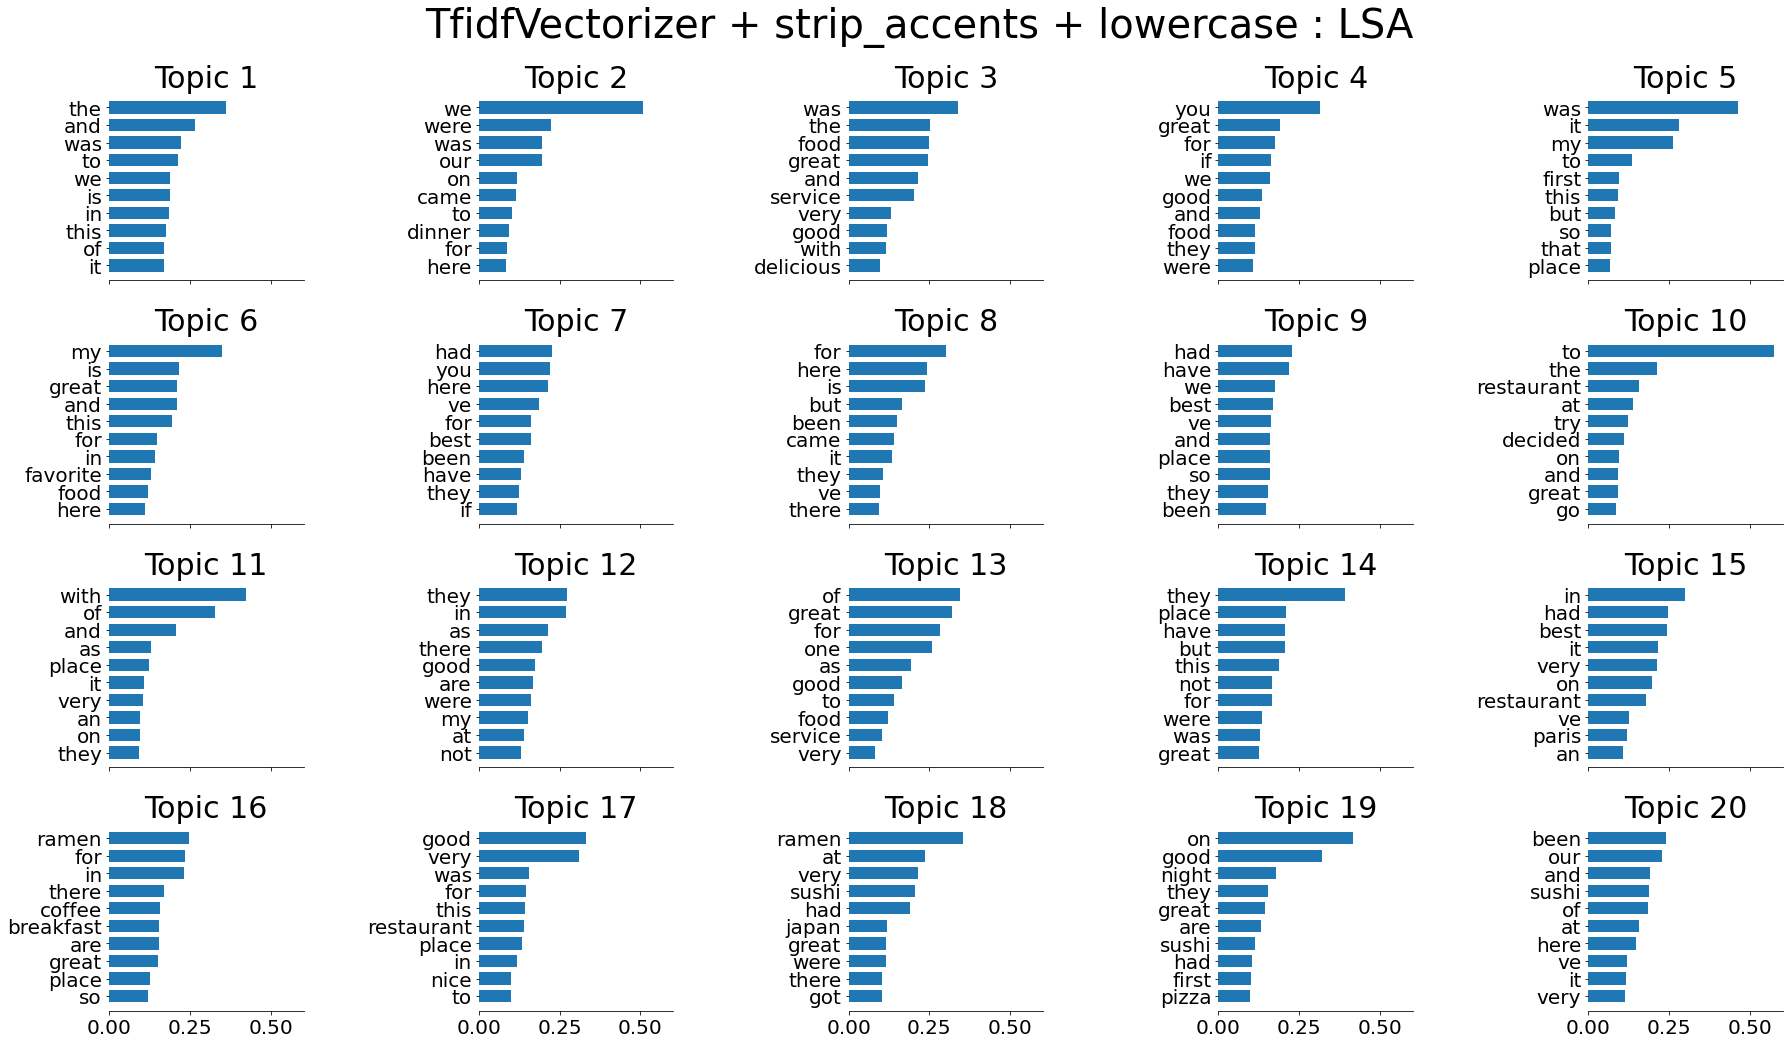

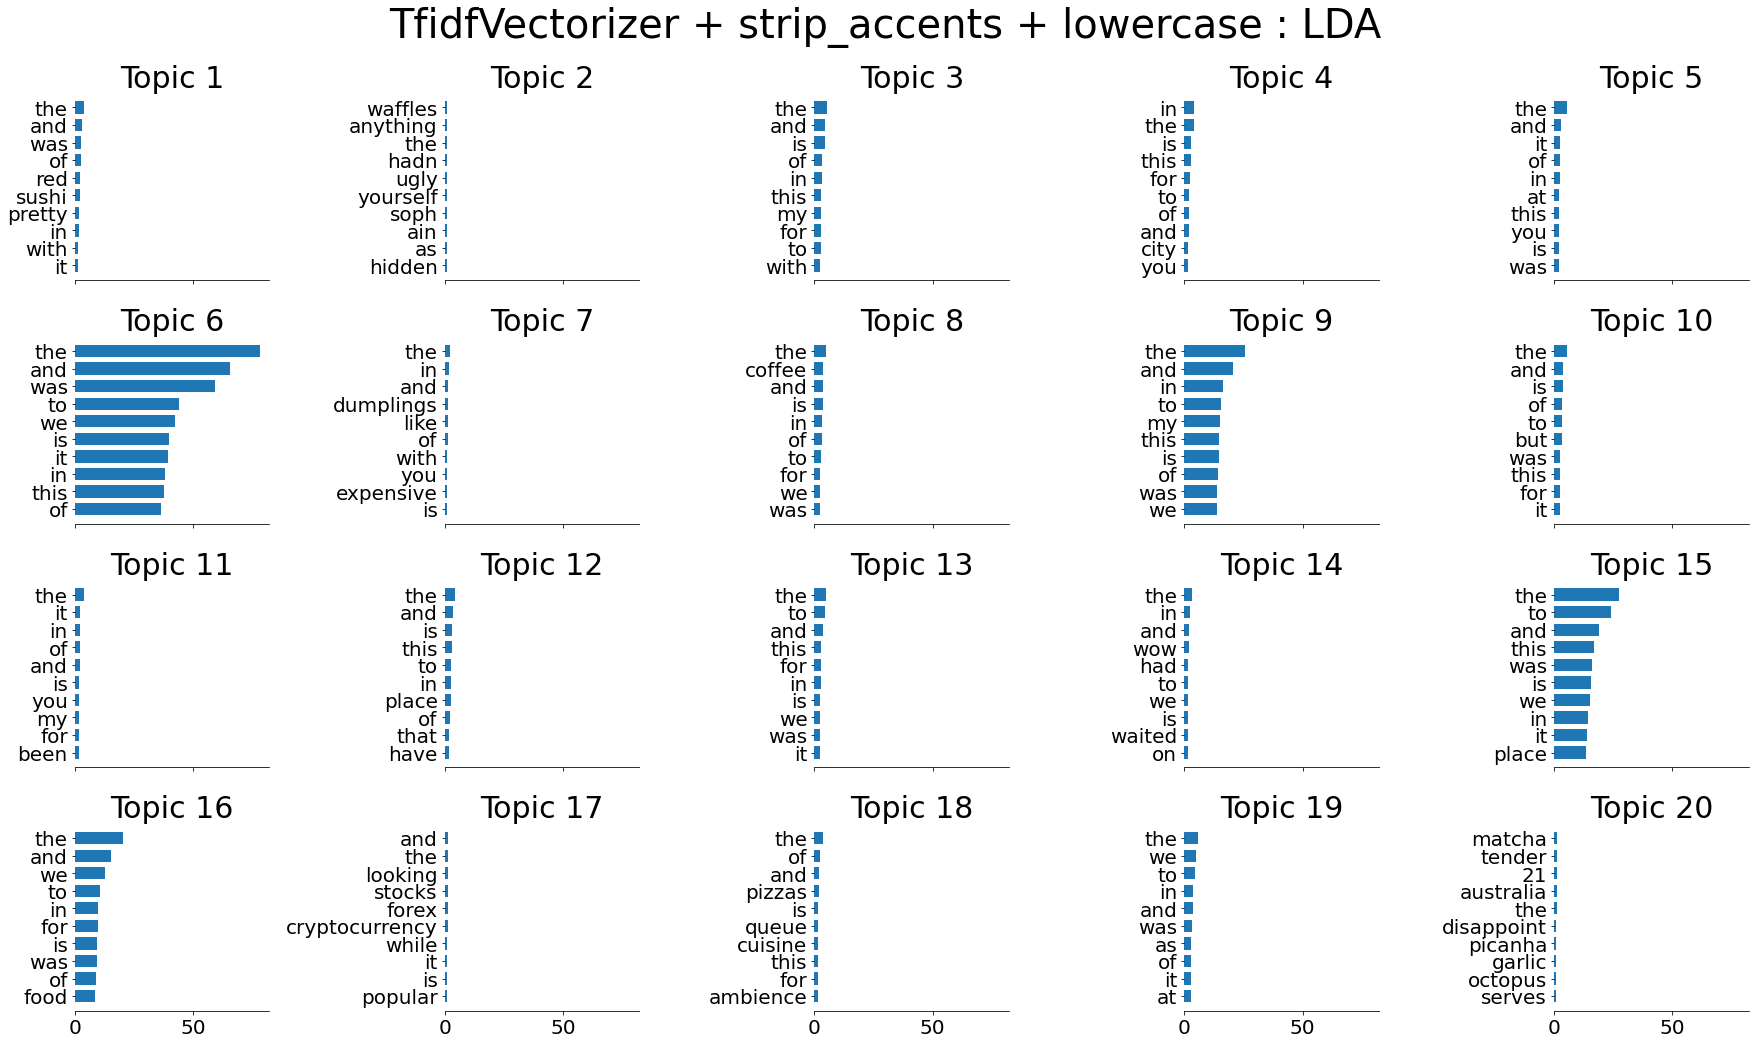

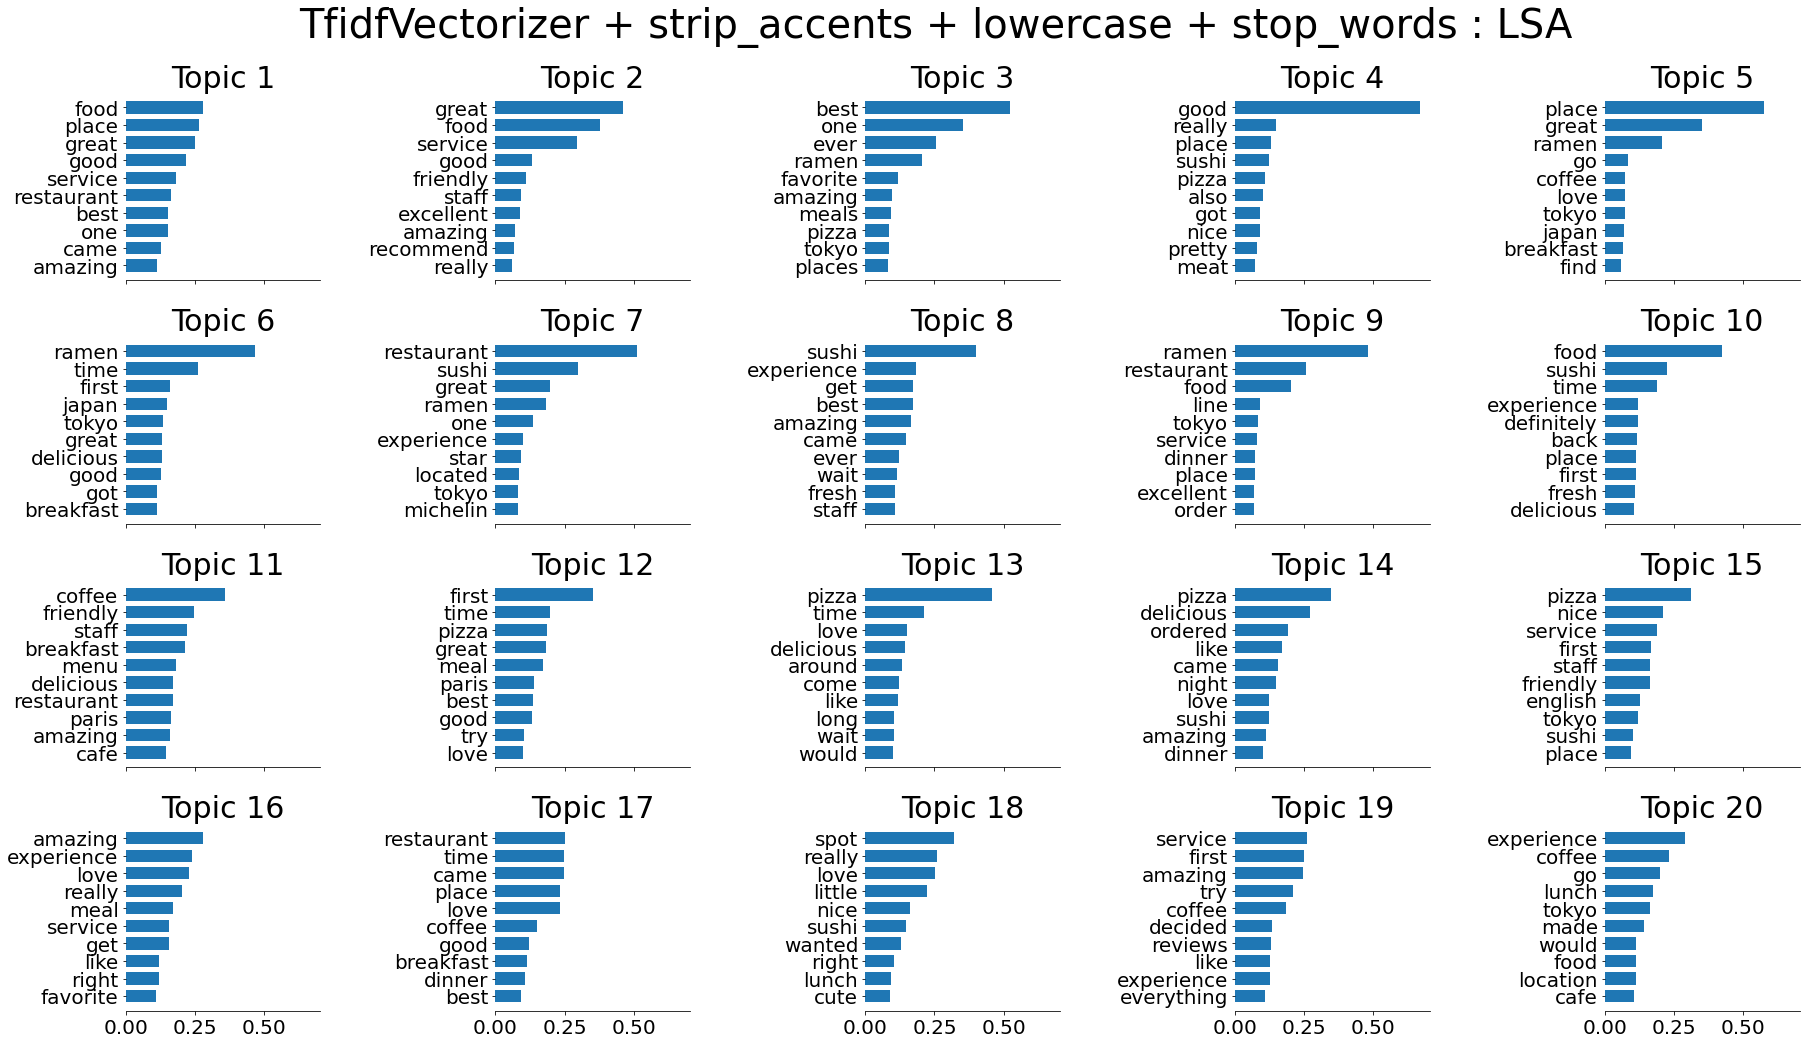

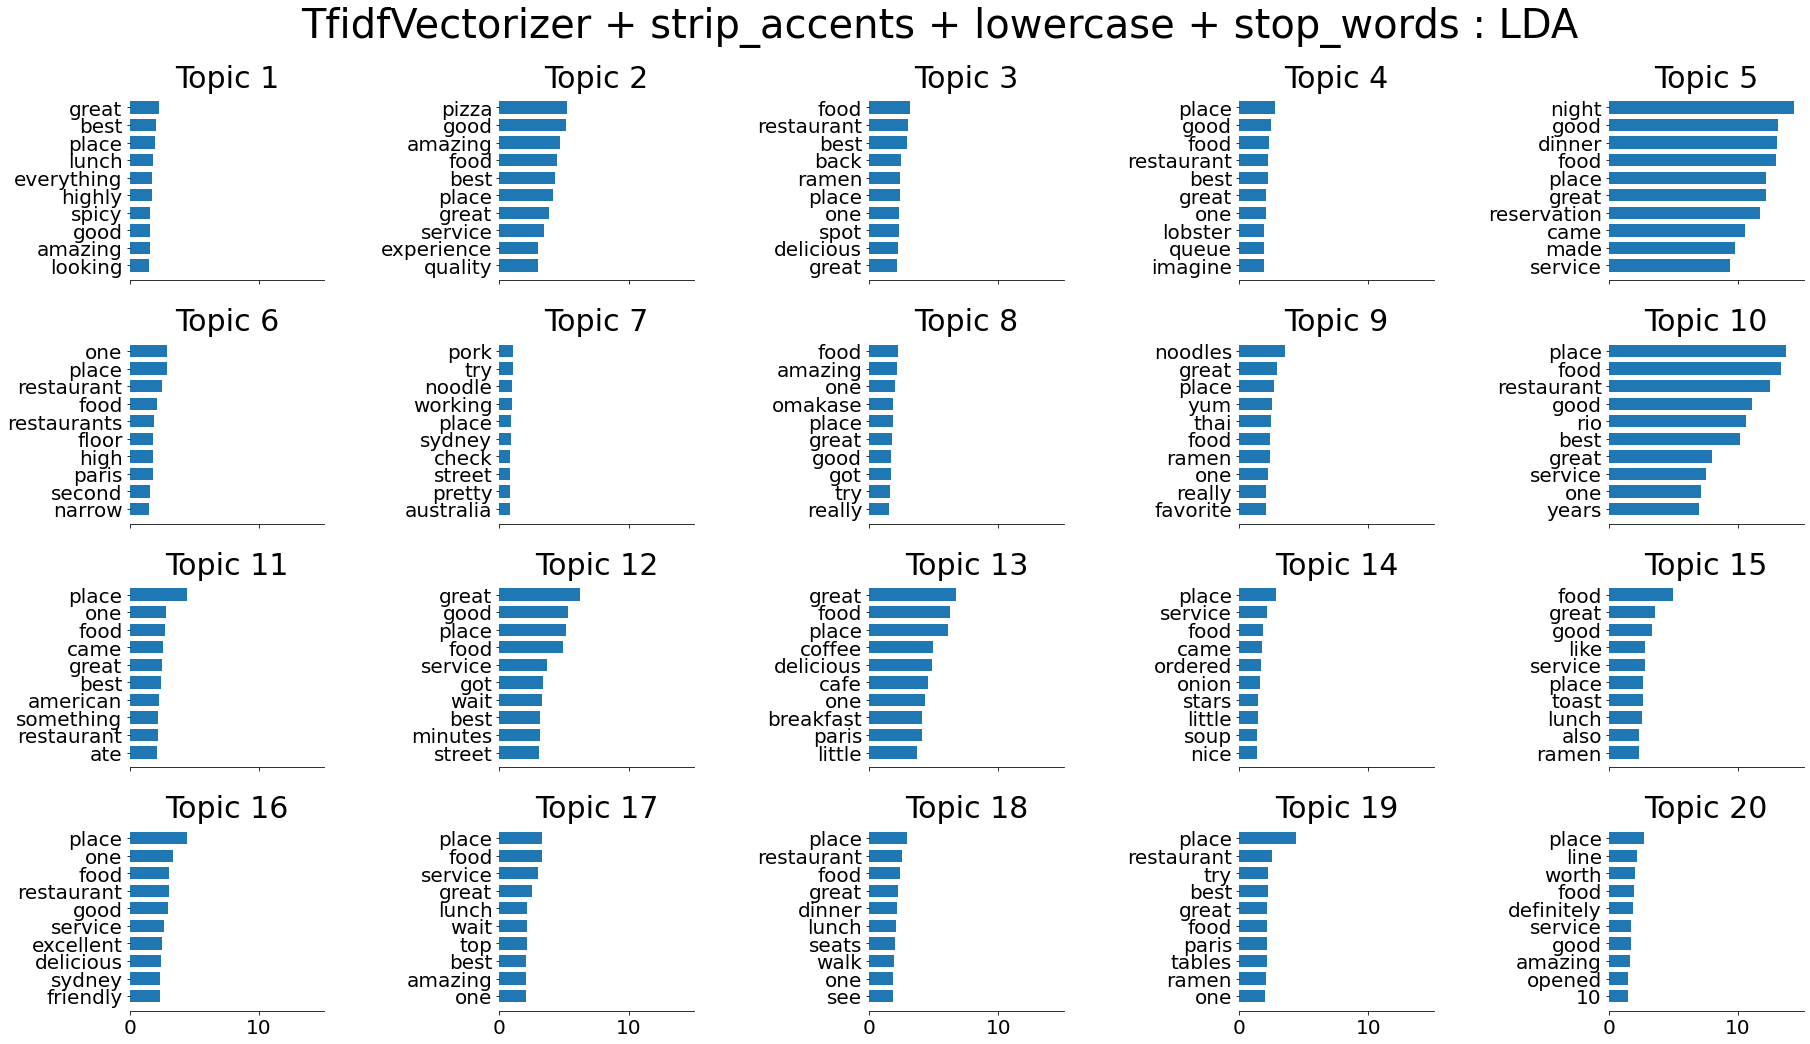

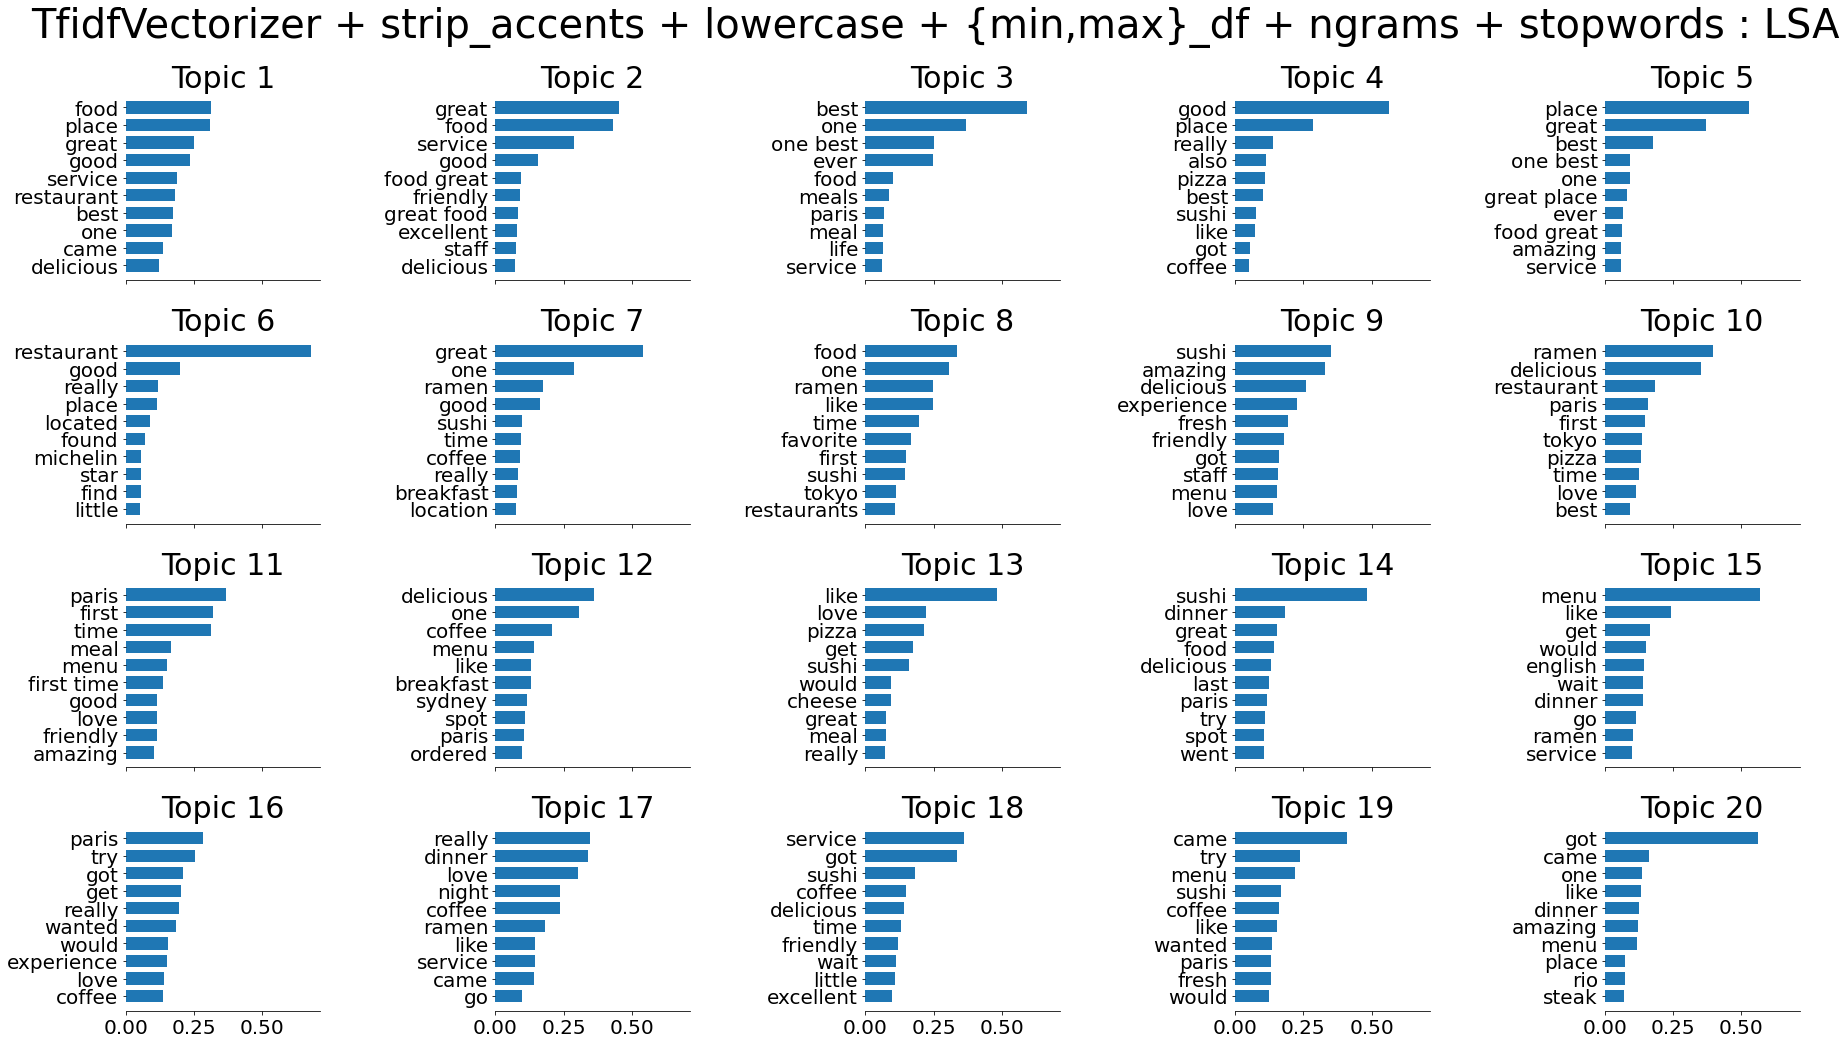

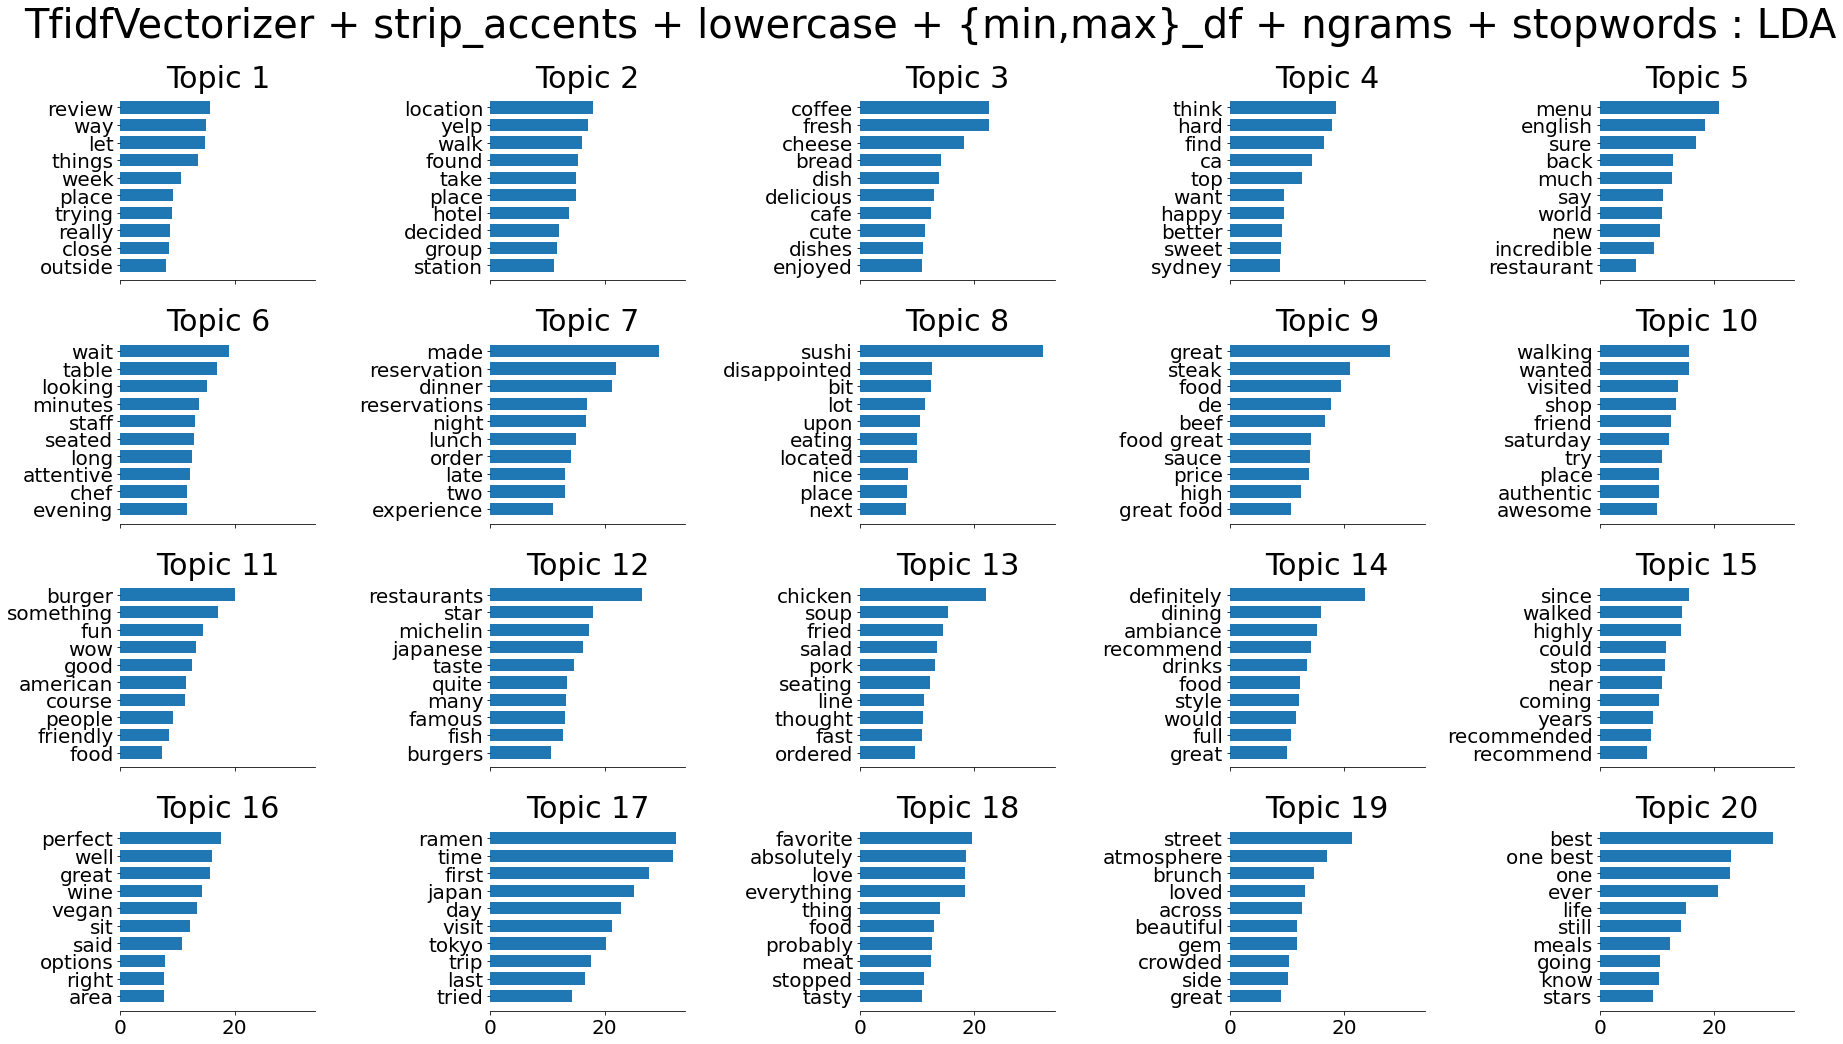

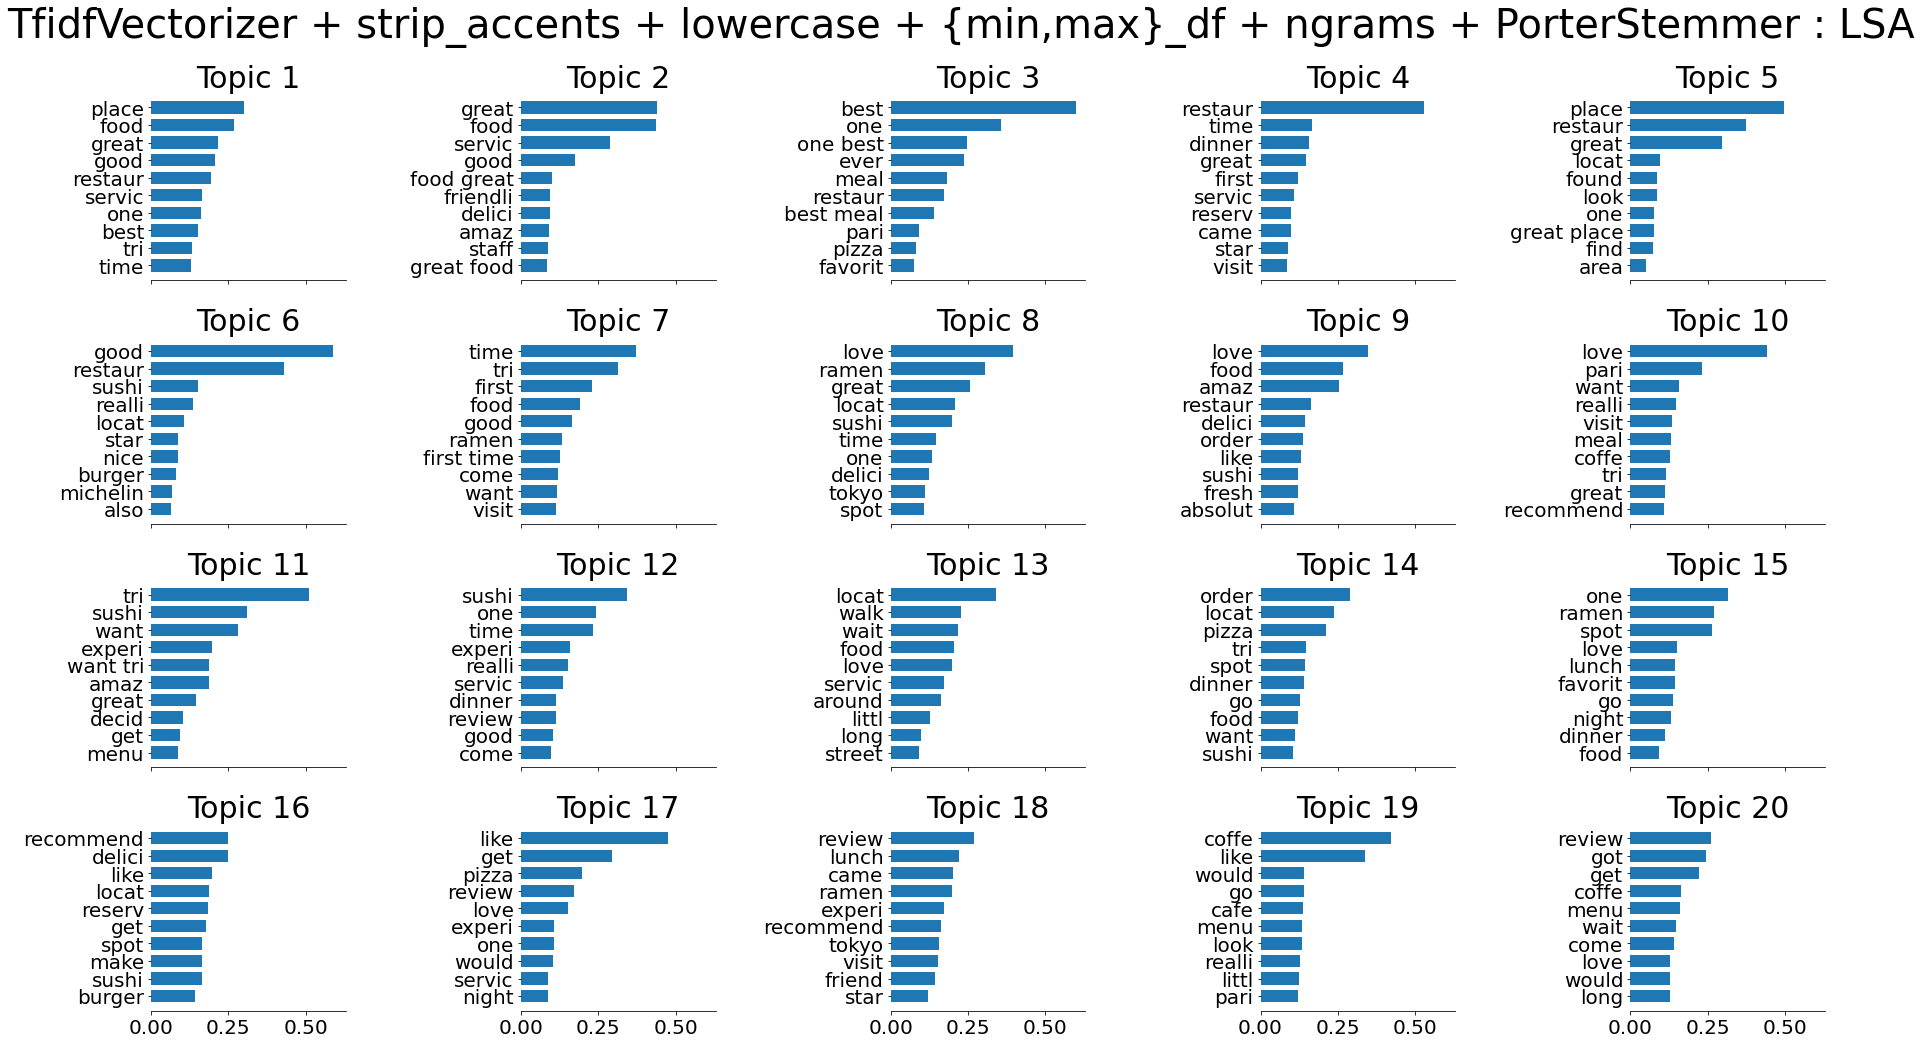

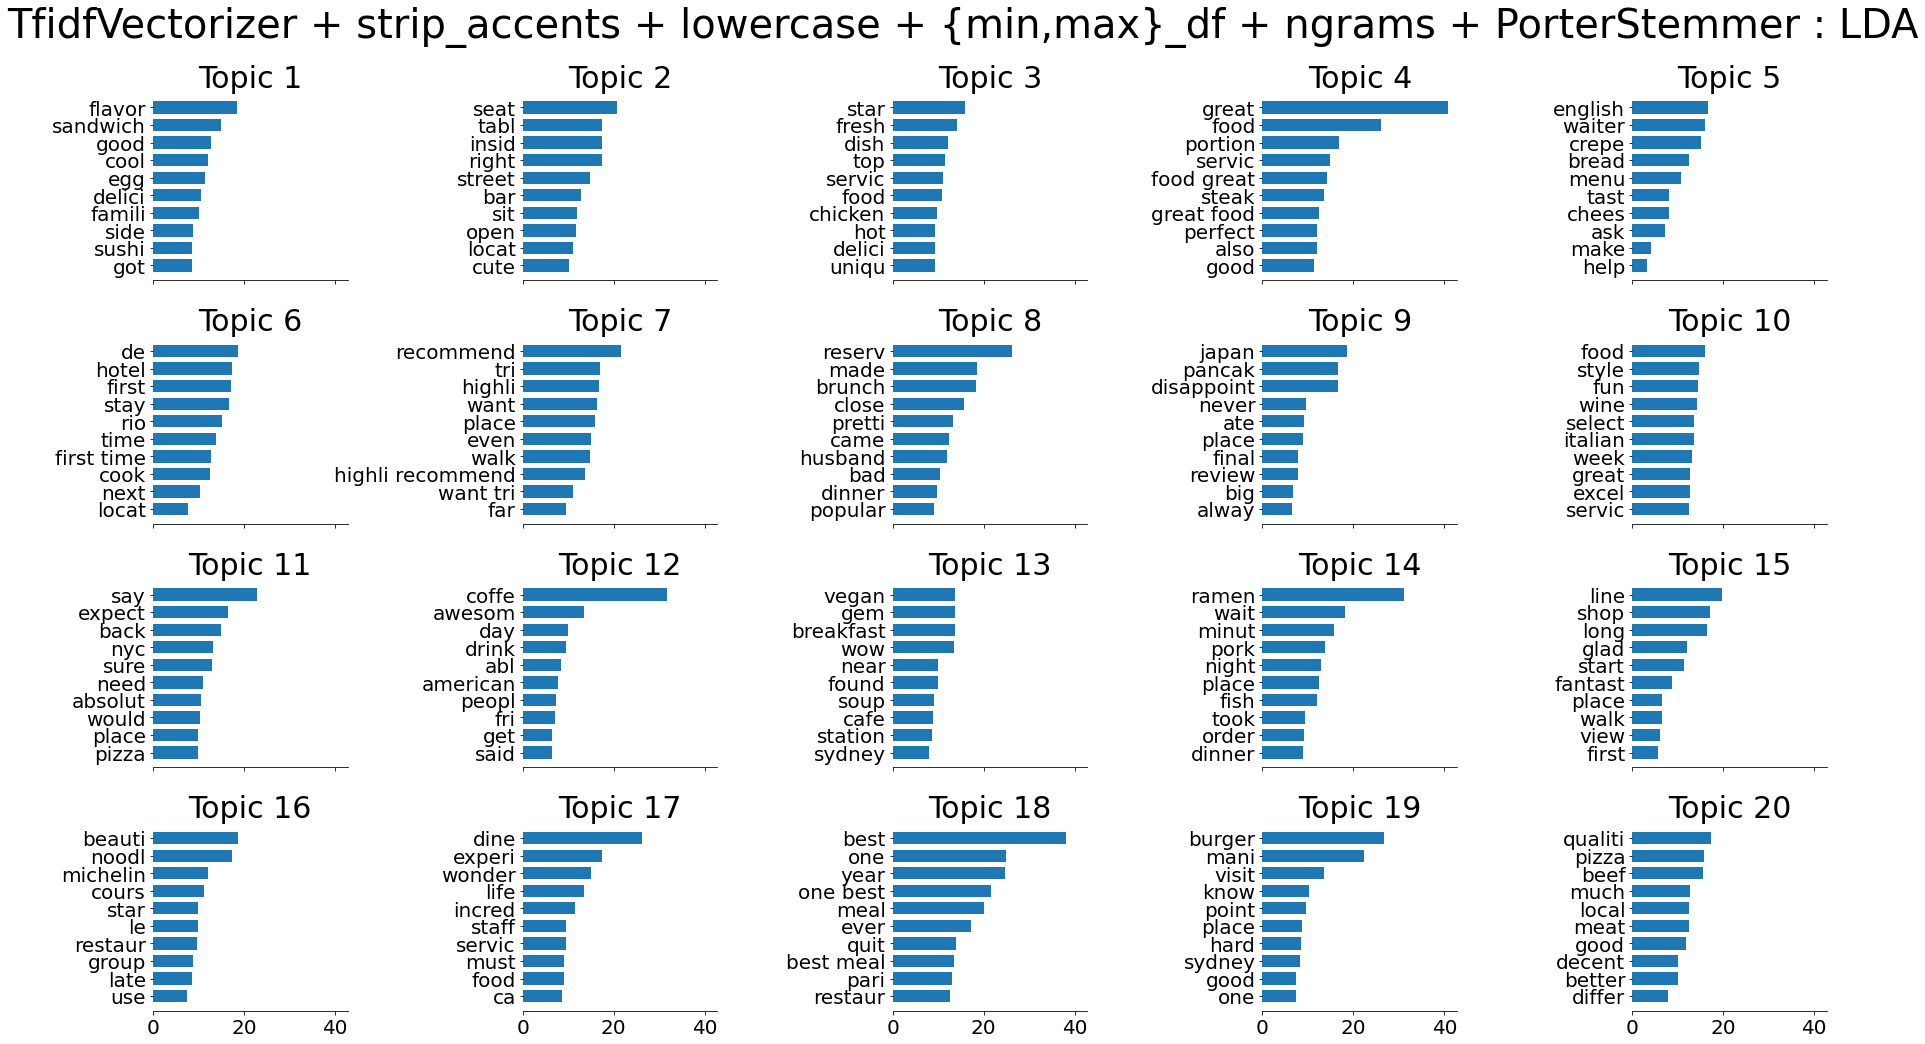

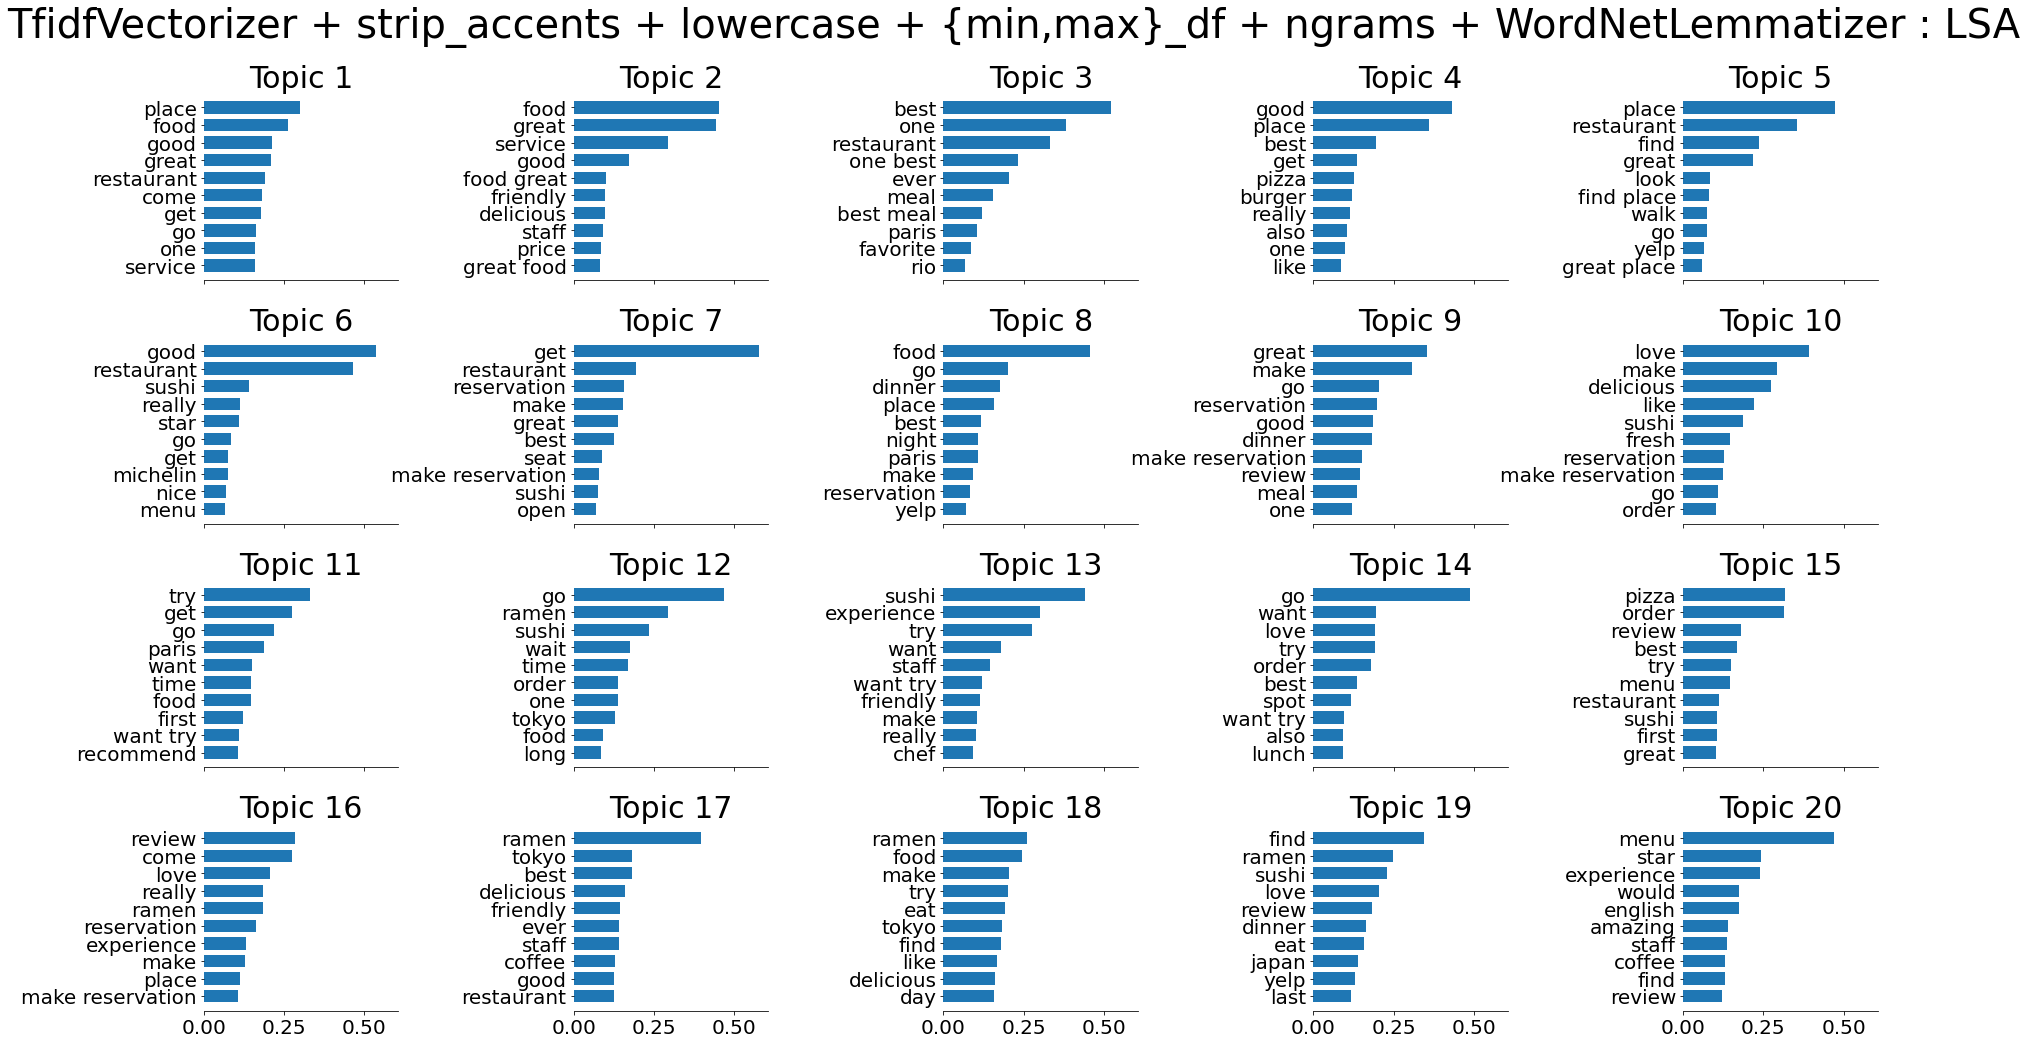

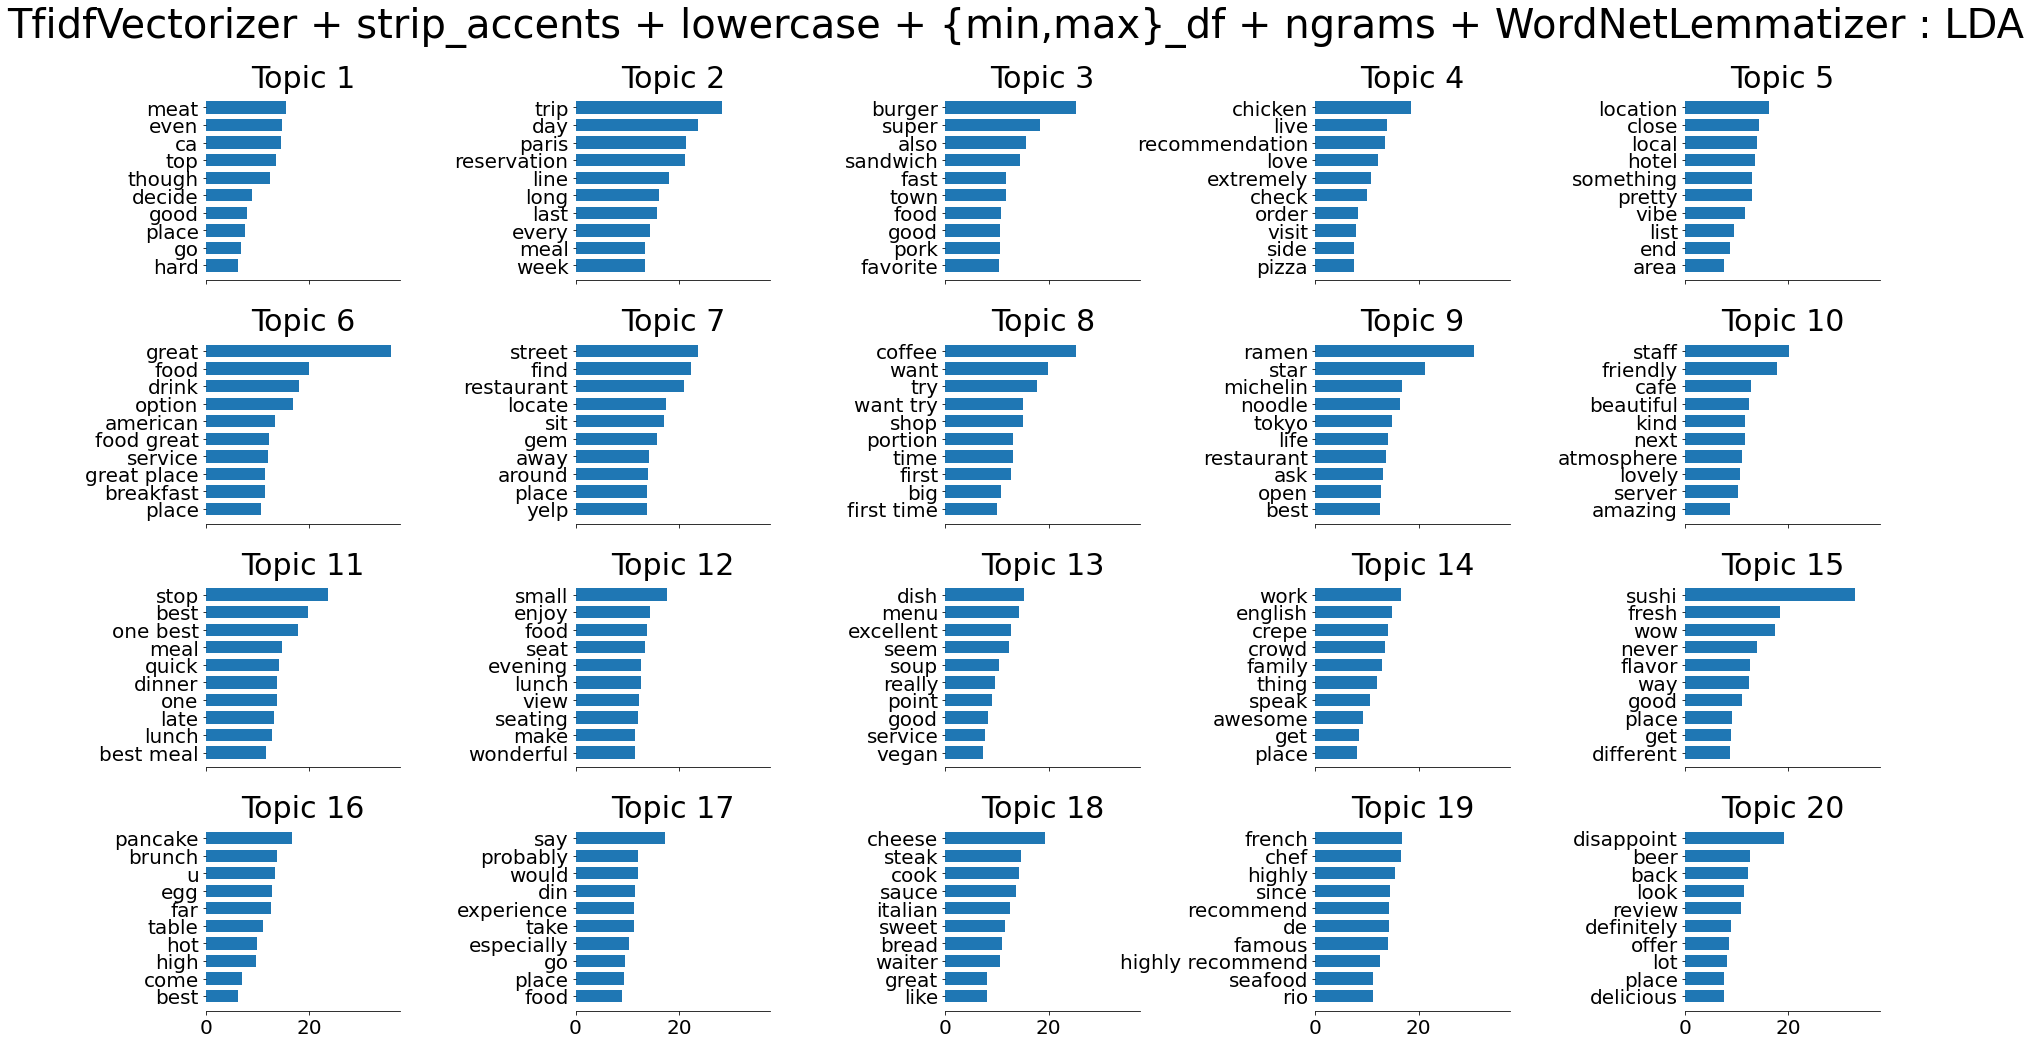

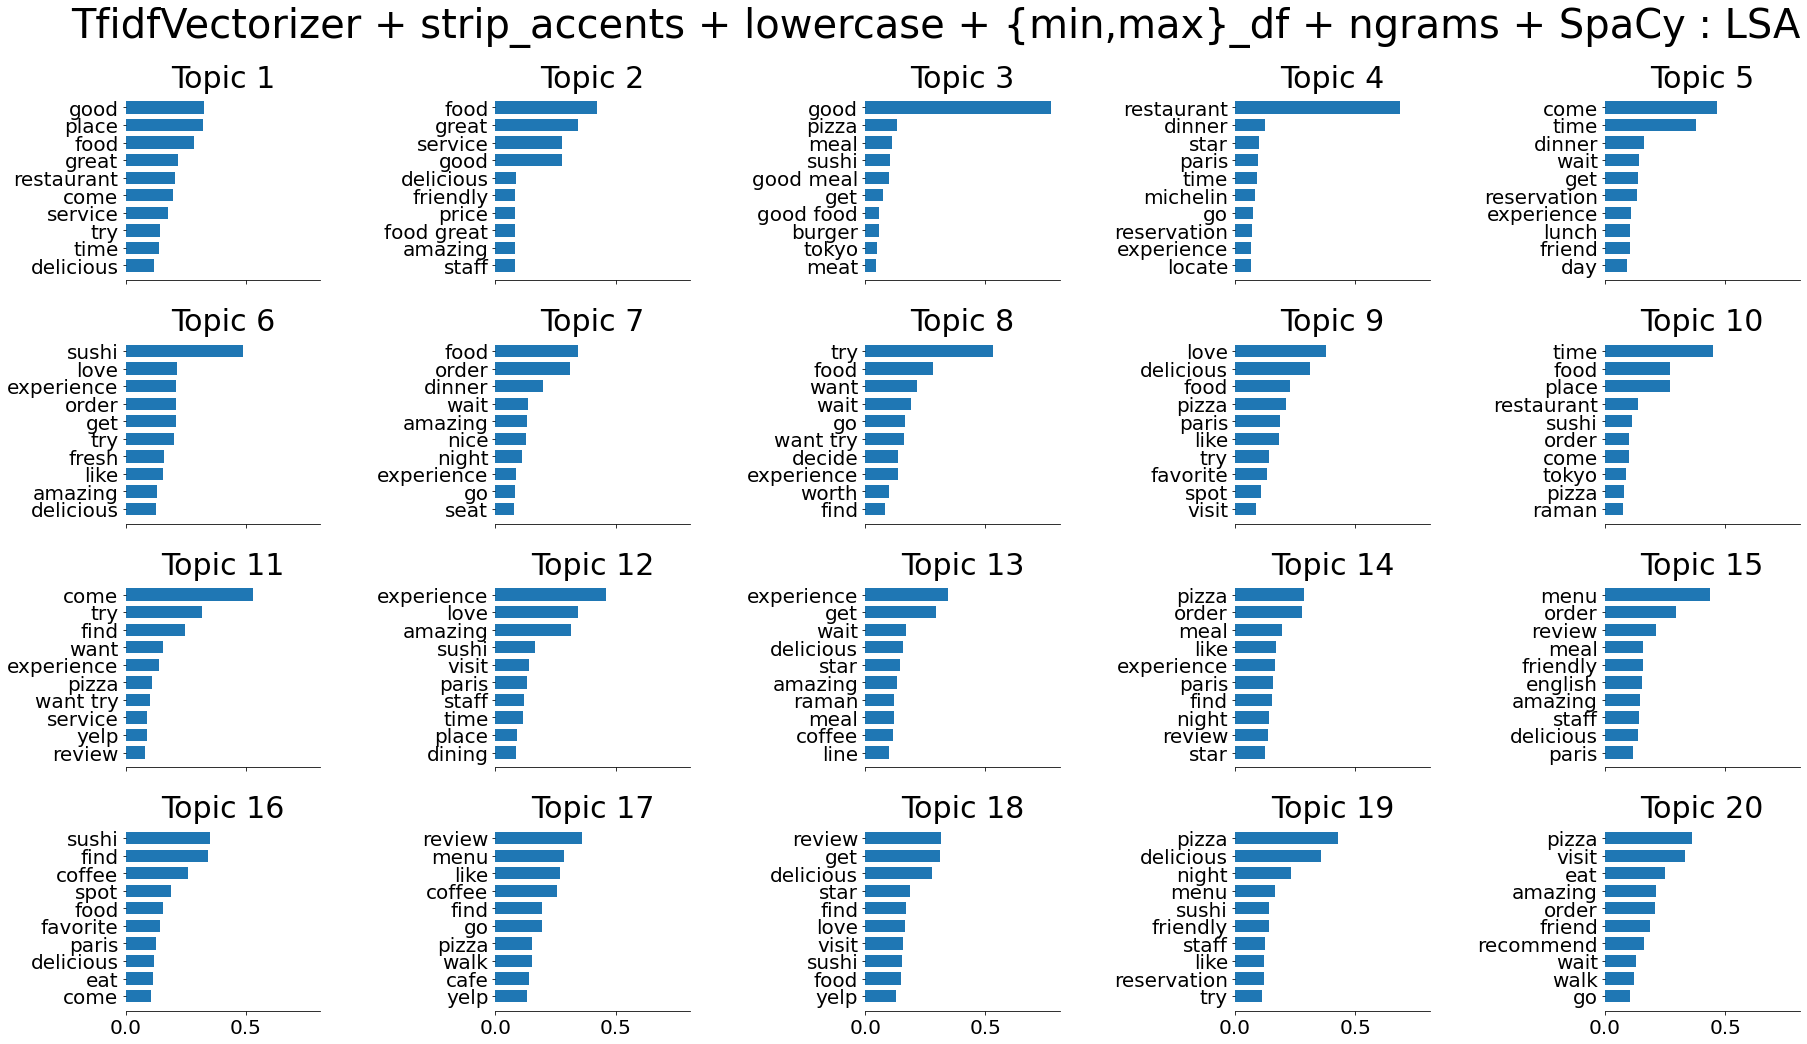

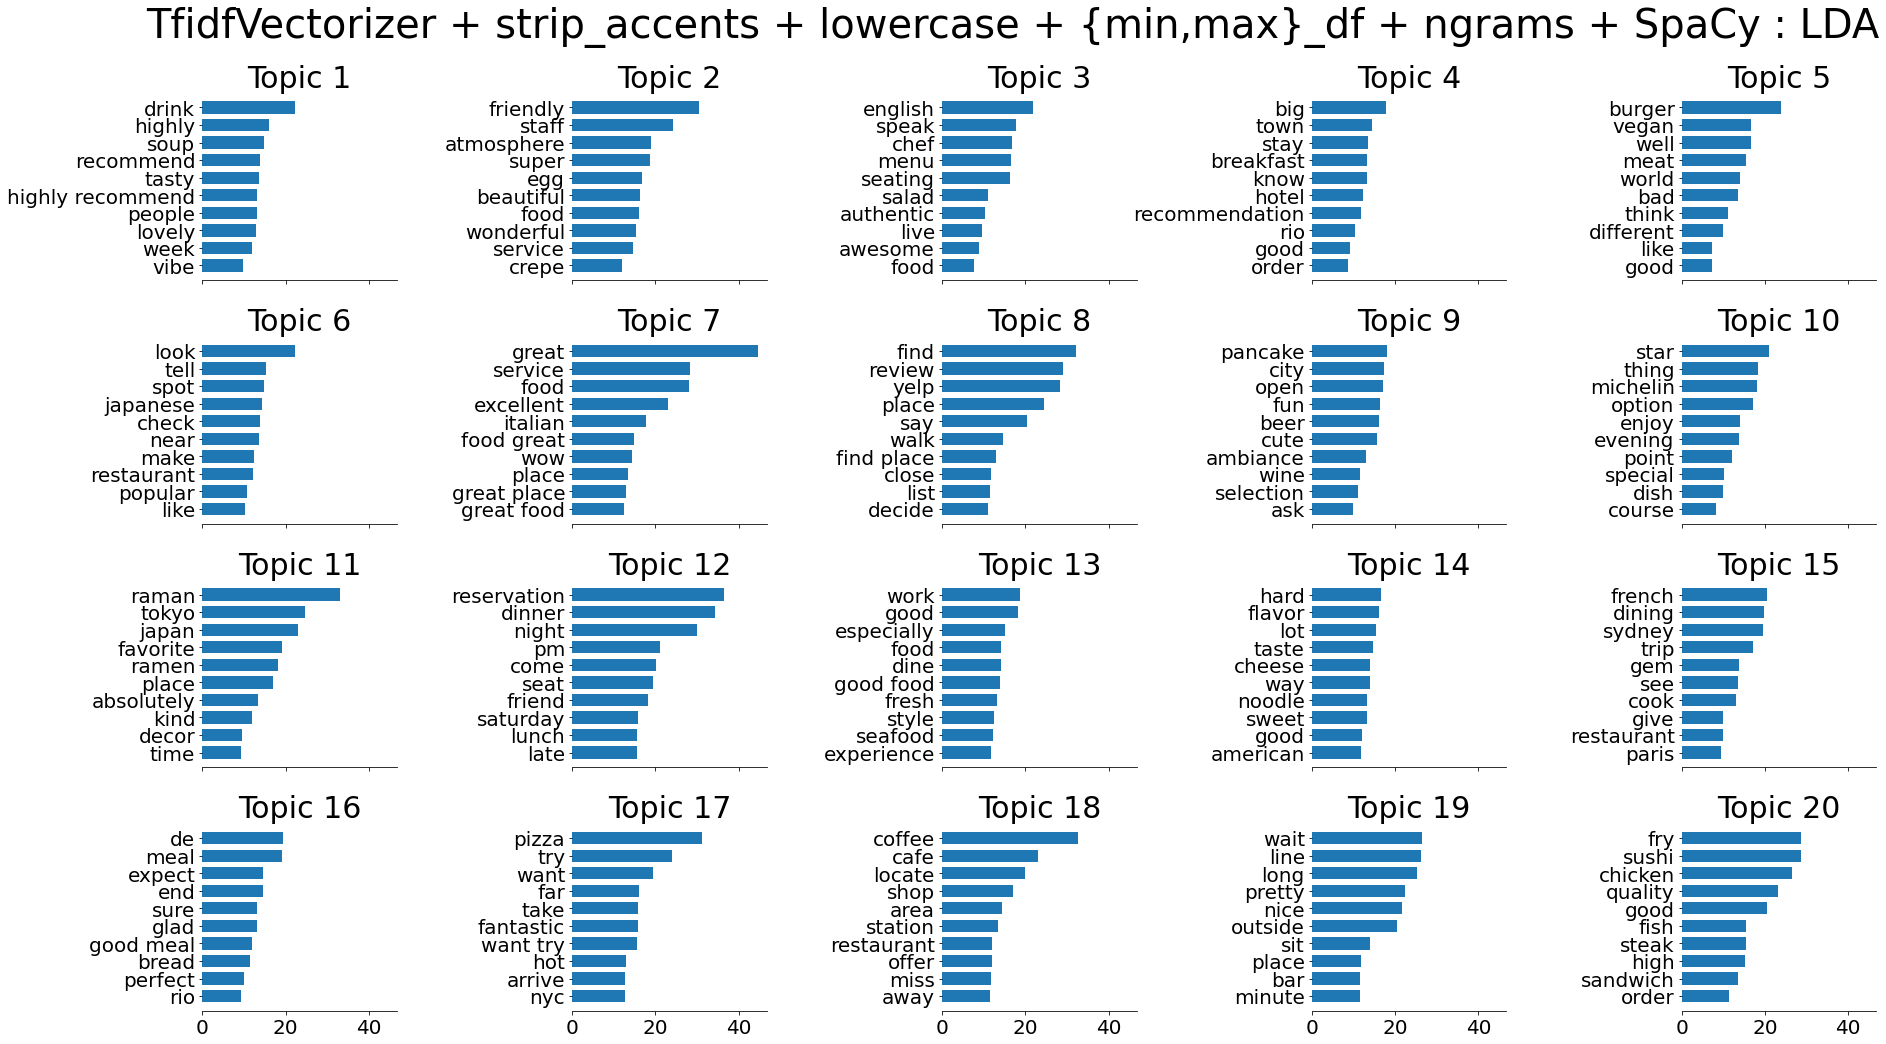

In [20]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation


def plot_top_words(model, feature_names, n_top_words, title):
    n_cols = 5
    n_lines = int(np.ceil(model.n_components / n_cols))
    fig, axes = plt.subplots(n_lines, n_cols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[0 : n_lines * n_cols]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


n_components = 20
for vectorizer_name in [
    "TfidfVectorizer + strip_accents + lowercase",
    "TfidfVectorizer + strip_accents + lowercase + stop_words",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + stopwords",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + PorterStemmer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + WordNetLemmatizer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy",
]:
    vectorizer = vectorizers[vectorizer_name]
    X_vec = vectorizer.fit_transform(X)

    words_count = pd.Series(
        X_vec.sum(axis=0).tolist()[0],
        index=vectorizer.get_feature_names(),
    )

    top_20_count = words_count.sort_values(ascending=False).head(20)

    fig = px.bar(
        top_20_count,
        x=top_20_count.index,
        y=top_20_count.values,
        labels={"x": "Word", "y": "Count"},
        title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
        color=top_20_count.values,
    )
    fig.show()

    lsa = TruncatedSVD(n_components=n_components, random_state=42)
    X_lsa = lsa.fit_transform(X_vec)

    fig = px.line(
        x=range(1, n_components + 1),
        y=np.cumsum(lsa.explained_variance_ratio_),
        labels={
            "x": "Principal Component",
            "y": "Explained Variance Ratio",
        },
        title=f"{vectorizer_name} : Explained Variance Ratio",
    )
    fig.show()

    fig = px.scatter_3d(
        X_lsa,
        x=X_lsa[:, 0],
        y=X_lsa[:, 1],
        z=X_lsa[:, 2],
        labels={"x": "Component 1", "y": "Component 2", "z": "Component 3"},
        title=f"{vectorizer_name} : SVD",
        color=y,
        opacity=0.5,
    )
    fig.show()

    plot_top_words(
        lsa, vectorizer.get_feature_names(), 10, f"{vectorizer_name} : LSA"
    )

    lda = LatentDirichletAllocation(
        n_components=n_components,
        random_state=42,
        n_jobs=-1,
    )
    X_lda = lda.fit_transform(X_vec)

    plot_top_words(
        lda, vectorizer.get_feature_names(), 10, f"{vectorizer_name} : LDA"
    )


In [21]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()


vectorizer = vectorizers[
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy"
]
X_vec = vectorizer.fit_transform(X)

lda = LatentDirichletAllocation(
    n_components=n_components,
    random_state=42,
    n_jobs=-1,
).fit(X_vec)

pyLDAvis.sklearn.prepare(lda, X_vec, vectorizer)


/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/pas

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.153218  0.063449       1        1  6.880288
6     -0.058924  0.083062       2        1  6.518643
18     0.011213  0.111132       3        1  6.018032
1     -0.183318  0.077310       4        1  5.840391
7      0.187053 -0.049567       5        1  5.783442
19    -0.124659 -0.135190       6        1  5.727336
16     0.039904 -0.122589       7        1  5.003818
5      0.100690  0.012111       8        1  4.907359
13    -0.090066 -0.140966       9        1  4.879131
10     0.051239 -0.043248      10        1  4.728211
14     0.110652  0.014372      11        1  4.675156
8     -0.023446  0.107551      12        1  4.667757
0     -0.115559  0.031011      13        1  4.649130
17     0.142011  0.127586      14        1  4.616146
12    -0.099363  0.023835      15        1  4.511682
9     -0.065190 -0.095985      16        1  4.352395
15     0.087207 -0.052632      17        1  4.239330
3      0.017546 -0.000182      18        1  4.150753
2     -0.131922  0.155947      19        1  4.103188
4     -0.008285 -0.167007      20        1  3.747812, topic_info=        Term       Freq       Total Category  logprob  loglift
166    raman  33.000000   33.000000  Default  30.0000  30.0000
33    coffee  38.000000   38.000000  Default  29.0000  29.0000
23    burger  35.000000   35.000000  Default  28.0000  28.0000
154    pizza  45.000000   45.000000  Default  27.0000  27.0000
217    tokyo  39.000000   39.000000  Default  26.0000  26.0000
..       ...        ...         ...      ...      ...      ...
89      good   7.657014  157.443223  Topic20  -3.5670   0.2606
92     great   3.919433  104.458345  Topic20  -4.2367   0.0012
155    place   4.674170  161.048264  Topic20  -4.0606  -0.2557
53       eat   2.561457   59.213066  Topic20  -4.6620   0.1434
2    amazing   2.508236   63.357642  Topic20  -4.6830   0.0548

[801 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.686552        able
0         3  0.124828        able
0         4  0.062414        able
0         8  0.062414        able
1         4  0.247579  absolutely
...     ...       ...         ...
239      17  0.165483        year
239      19  0.027581        year
239      20  0.165483        year
240       5  0.921394        yelp
240      11  0.035438        yelp

[1495 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 7, 19, 2, 8, 20, 17, 6, 14, 11, 15, 9, 1, 18, 13, 10, 16, 4, 3, 5])

#### Gensim LDA


In [22]:
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary


docs = X.map(tokenizers["SpaCy"])
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

results_lda = []
for num_topics in np.linspace(5, 200, 50, dtype=int):
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        per_word_topics=True,
        passes=10,
        random_state=42,
    )

    results = {
        "num_topics": num_topics,
        "perplexity": lda.log_perplexity(corpus), # Compute Perplexity (lower is better)
        "coherence": CoherenceModel(lda, texts=docs).get_coherence(),# Compute Coherence Score (higher is better)
    }
    results_lda.append(results)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=pd.DataFrame(results_lda)["num_topics"],
        y=pd.DataFrame(results_lda)["perplexity"],
        name="Perplexity",
        mode="lines",
    ),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=pd.DataFrame(results_lda)["num_topics"],
        y=pd.DataFrame(results_lda)["coherence"],
        name="Coherence",
        mode="lines",
    ),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="LDA Coherence and Perplexity",
    xaxis_title="Number of Topics",
    yaxis_title="Perplexity",
    yaxis2_title="Coherence",
)
fig.show()


/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



In [31]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_components,
    per_word_topics=True,
    passes=10,
    random_state=42,
)

pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)


/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.020278  0.132201       1        1  7.795475
14    -0.137859  0.165577       2        1  7.550518
7      0.139333  0.104394       3        1  7.379103
8     -0.073360  0.099095       4        1  6.283450
13     0.102299 -0.085504       5        1  5.705420
15    -0.013587  0.010556       6        1  5.360638
2      0.017802 -0.101167       7        1  5.168748
16    -0.067931  0.059733       8        1  5.079893
18     0.235806  0.106270       9        1  4.992095
9     -0.027880 -0.055258      10        1  4.857332
0     -0.067819 -0.039870      11        1  4.411545
10    -0.108946 -0.068883      12        1  4.374664
17     0.073381  0.014572      13        1  4.350293
12    -0.024431 -0.050671      14        1  4.248652
3      0.010546 -0.075263      15        1  4.095682
11    -0.048319 -0.047284      16        1  3.888459
19    -0.035789  0.037187      17        1  3.806587
6     -0.064880 -0.098119      18        1  3.698496
4     -0.008781 -0.002479      19        1  3.658430
5      0.120691 -0.105086      20        1  3.294520, topic_info=          Term        Freq       Total Category  logprob  loglift
640      pizza  133.000000  133.000000  Default  30.0000  30.0000
15        food  631.000000  631.000000  Default  29.0000  29.0000
409      staff  113.000000  113.000000  Default  28.0000  28.0000
17        good  709.000000  709.000000  Default  27.0000  27.0000
658      order  195.000000  195.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
733      world    7.839641   34.508780  Topic20  -5.0464   1.9309
160      thing    8.198594   70.778260  Topic20  -5.0016   1.2573
219      start    7.259332   53.011217  Topic20  -5.1233   1.4247
24        come    7.468930  392.800464  Topic20  -5.0948  -0.5496
83   beautiful    7.064737   59.989753  Topic20  -5.1505   1.2739

[1286 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
642      16  0.828965  ability
286       3  0.121423     able
286       7  0.182135     able
286       9  0.637471     able
286      18  0.030356     able
...     ...       ...      ...
224      17  0.969653      yum
225       2  0.085751    yummy
225      17  0.886092    yummy
3459     20  0.858820     zero
3767     14  0.787813        à

[3108 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 15, 8, 9, 14, 16, 3, 17, 19, 10, 1, 11, 18, 13, 4, 12, 20, 7, 5, 6])

In [33]:
from gensim.models import HdpModel


hdp = HdpModel(
    corpus=corpus,
    id2word=dictionary,
    # T=n_components, # Maximum number of topics
    random_state=42,
)

pyLDAvis.gensim_models.prepare(hdp, corpus, dictionary)


/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27     0.001359  0.016444       1        1  4.942430
13     0.005773  0.013957       2        1  3.666999
55     0.014283  0.002479       3        1  3.170918
2      0.016825 -0.004298       4        1  2.770190
3      0.010997 -0.003438       5        1  2.679173
...         ...       ...     ...      ...       ...
135   -0.001113  0.014617     146        1  0.082584
137   -0.000290  0.014658     147        1  0.076497
147   -0.006929 -0.008509     148        1  0.074345
126   -0.000485 -0.003231     149        1  0.049611
138    0.013809  0.014231     150        1  0.031544

[150 rows x 5 columns], topic_info=             Term       Freq      Total  Category  logprob  loglift
21          place  32.000000  32.000000   Default  30.0000  30.0000
111         great  26.000000  26.000000   Default  29.0000  29.0000
482   exceptional   9.000000   9.000000   Default  28.0000  28.0000
15           food  33.000000  33.000000   Default  27.0000  27.0000
930         musée   9.000000   9.000000   Default  26.0000  26.0000
...           ...        ...        ...       ...      ...      ...
4462       peking   0.012995   8.245272  Topic150  -6.8002   1.6087
3407        curve   0.013870   9.101907  Topic150  -6.7350   1.5750
1333      hostess   0.012908   8.510234  Topic150  -6.8068   1.5704
1616       awhile   0.011795   7.670120  Topic150  -6.8970   1.5842
2243          pho   0.012394   8.921810  Topic150  -6.8475   1.4825

[5879 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2186      6  0.256028          ab
5042      1  0.129483     abalone
5042      3  0.129483     abalone
4446     10  0.149925    absinthe
556       3  0.103037  absolutely
...     ...       ...         ...
1545      1  0.230659        yuzu
1545      2  0.115330        yuzu
3459      7  0.144136        zero
1496      3  0.130678      zombie
3969      4  0.161972        zona

[3666 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 14, 56, 3, 4, 5, 103, 57, 39, 1, 8, 70, 101, 21, 10, 47, 77, 52, 32, 2, 51, 30, 115, 13, 43, 69, 78, 132, 27, 105, 41, 16, 25, 40, 6, 85, 73, 44, 65, 63, 82, 71, 99, 75, 24, 35, 58, 33, 59, 36, 55, 124, 86, 9, 76, 29, 22, 81, 38, 7, 74, 11, 42, 72, 87, 54, 26, 79, 31, 60, 92, 64, 102, 128, 19, 93, 111, 12, 142, 68, 141, 48, 53, 61, 88, 45, 129, 108, 116, 20, 104, 37, 133, 46, 89, 110, 34, 143, 144, 98, 137, 117, 23, 15, 83, 91, 17, 84, 109, 120, 107, 49, 66, 149, 97, 67, 62, 95, 147, 112, 90, 135, 18, 113, 123, 118, 106, 80, 96, 145, 100, 126, 125, 140, 146, 134, 130, 150, 94, 50, 122, 119, 121, 114, 131, 136, 138, 148, 127, 139])

### Word Embedding


In [34]:
from gensim.models.word2vec import Word2Vec


word2vec = Word2Vec(docs)
word2vec.wv.most_similar(["sushi", "rio"], ["tokyo"], topn=20)


[('decide', 0.9993099570274353),
 ('spot', 0.9992930293083191),
 ('experience', 0.9992882609367371),
 ('french', 0.9992833137512207),
 ('nyc', 0.9992756843566895),
 ('start', 0.9992687106132507),
 ('day', 0.9992682933807373),
 ('locate', 0.9992637634277344),
 ('place', 0.9992631673812866),
 ('restaurant', 0.9992530345916748),
 ('table', 0.9992516040802002),
 ('service', 0.9992508292198181),
 ('get', 0.9992462396621704),
 ('cook', 0.999243974685669),
 ('dinner', 0.9992406368255615),
 ('food', 0.999238908290863),
 ('like', 0.9992307424545288),
 ('visit', 0.9992262721061707),
 ('amazing', 0.9992206692695618),
 ('good', 0.9992197155952454)]

In [35]:
from sklearn.manifold import TSNE


X_w2v = [word2vec.wv[x] for x in word2vec.wv.key_to_index.keys()]
X_tsne = TSNE().fit_transform(X_w2v)

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    text=word2vec.wv.key_to_index.keys(),
    labels={"x": "Component 1", "y": "Component 2"},
    title="Word2Vec TSNE",
)
fig.show()


### Fasttext


In [36]:
from gensim.models.fasttext import FastText


fasttext = FastText(docs)
fasttext.wv.most_similar(["sushi", "rio"], ["tokyo"], topn=20)


[('super', 0.9999285340309143),
 ('butter', 0.9999273419380188),
 ('choice', 0.9999271035194397),
 ('lobster', 0.999925434589386),
 ('diner', 0.9999250769615173),
 ('affordable', 0.9999240636825562),
 ('later', 0.999923586845398),
 ('knowledgeable', 0.999923586845398),
 ('reasonable', 0.999923586845398),
 ('tasting', 0.9999221563339233),
 ('charming', 0.9999217391014099),
 ('cheese', 0.9999217391014099),
 ('fantastic', 0.9999217391014099),
 ('notice', 0.9999215006828308),
 ('treat', 0.9999212622642517),
 ('break', 0.9999207854270935),
 ('fritter', 0.9999207258224487),
 ('temple', 0.9999206066131592),
 ('ingredient', 0.9999204277992249),
 ('expectation', 0.9999201893806458)]

In [37]:
from sklearn.manifold import TSNE


X_w2v = [fasttext.wv[x] for x in fasttext.wv.key_to_index.keys()]
X_tsne = TSNE().fit_transform(X_w2v)

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    text=fasttext.wv.key_to_index.keys(),
    labels={"x": "Component 1", "y": "Component 2"},
    title="FastText TSNE",
)
fig.show()
